## Problem Statement:

An online money lending platform committed to delivering customized loan products to millennials. They innovate in an otherwise dull loan segment, to deliver instant, flexible loans on consumer friendly terms to salaried professionals and businessmen.


The data science team at this money lending platform is building an underwriting layer to determine the creditworthiness of MSMEs as well as individuals.

They deploys formal credit to salaried individuals and businesses in 4 main financial instruments:
1. Personal Loan
2. EMI Free Loan
3. Personal Overdraft
4. Advance Salary Loan

This case study will focus on the underwriting process behind Personal Loan only. Given a set of attributes for an Individual, determine if a credit line should be extended to them. If so, what should the repayment terms be in business recommendations? Identify real defaulters and reduce Non Performing Asset for the money lending company so that company can play safe and increase opportunities to finance more individuals and earn more profit.

In [412]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [413]:
import warnings 
warnings.filterwarnings('ignore')

In [592]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, precision_recall_curve,\
                             roc_auc_score, roc_curve, auc,plot_confusion_matrix, plot_roc_curve, ConfusionMatrixDisplay)
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE

In [415]:
loan_data = pd.read_csv('logistic_regression.csv')
loan_data.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,...,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,...,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,...,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,...,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,...,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\r\nGreggshire, VA 11650"


In [416]:
loan_data.tail()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
396025,10000.0,60 months,10.99,217.38,B,B4,licensed bankere,2 years,RENT,40000.0,...,6.0,0.0,1990.0,34.3,23.0,w,INDIVIDUAL,0.0,0.0,"12951 Williams Crossing\r\nJohnnyville, DC 30723"
396026,21000.0,36 months,12.29,700.42,C,C1,Agent,5 years,MORTGAGE,110000.0,...,6.0,0.0,43263.0,95.7,8.0,f,INDIVIDUAL,1.0,0.0,"0114 Fowler Field Suite 028\r\nRachelborough, ..."
396027,5000.0,36 months,9.99,161.32,B,B1,City Carrier,10+ years,RENT,56500.0,...,15.0,0.0,32704.0,66.9,23.0,f,INDIVIDUAL,0.0,0.0,"953 Matthew Points Suite 414\r\nReedfort, NY 7..."
396028,21000.0,60 months,15.31,503.02,C,C2,"Gracon Services, Inc",10+ years,MORTGAGE,64000.0,...,9.0,0.0,15704.0,53.8,20.0,f,INDIVIDUAL,5.0,0.0,"7843 Blake Freeway Apt. 229\r\nNew Michael, FL..."
396029,2000.0,36 months,13.61,67.98,C,C2,Internal Revenue Service,10+ years,RENT,42996.0,...,3.0,0.0,4292.0,91.3,19.0,f,INDIVIDUAL,NaN,0.0,"787 Michelle Causeway\r\nBriannaton, AR 48052"


__Let's check shape & characteristics of the dataset__

In [417]:
# Shape of the dataset -
print("No. of rows: ", loan_data.shape[0])
print("No. of columns: ", loan_data.shape[1])

No. of rows:  396030
No. of columns:  27


In [418]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394275 non-null  object 
 15  

In [419]:
loan_data['loan_status'].dtype

dtype('O')

In [420]:
object_list, obj_val = [], []
number_list, num_val = [], []
for i in loan_data.columns:
    if loan_data[i].dtype == 'O':
        object_list.append(i)
        obj_val.append(loan_data[i].unique())
    else:
        number_list.append(i)
        num_val.append(loan_data[i].unique())
        
obj_data = pd.DataFrame({'Object_Cols':object_list, 'obj_val':obj_val})
num_data = pd.DataFrame({'Number_Cols':number_list, 'num_val':num_val})

In [421]:
obj_data

,Object_Cols,obj_val
0,term,"[ 36 months, 60 months]"
1,grade,"[B, A, C, E, D, F, G]"
2,sub_grade,"[B4, B5, B3, A2, C5, C3, A1, B2, C1, A5, E4, A..."
3,emp_title,"[Marketing, Credit analyst , Statistician, Cli..."
4,emp_length,"[10+ years, 4 years, < 1 year, 6 years, 9 year..."
5,home_ownership,"[RENT, MORTGAGE, OWN, OTHER, NONE, ANY]"
6,verification_status,"[Not Verified, Source Verified, Verified]"
7,issue_d,"[Jan-2015, Nov-2014, Apr-2013, Sep-2015, Sep-2..."
8,loan_status,"[Fully Paid, Charged Off]"
9,purpose,"[vacation, debt_consolidation, credit_card, ho..."


In [422]:
num_data

,Number_Cols,num_val
0,loan_amnt,"[10000.0, 8000.0, 15600.0, 7200.0, 24375.0, 20..."
1,int_rate,"[11.44, 11.99, 10.49, 6.49, 17.27, 13.33, 5.32..."
2,installment,"[329.48, 265.68, 506.97, 220.65, 609.33, 677.0..."
3,annual_inc,"[117000.0, 65000.0, 43057.0, 54000.0, 55000.0,..."
4,dti,"[26.24, 22.05, 12.79, 2.6, 33.95, 16.31, 1.36,..."
5,open_acc,"[16.0, 17.0, 13.0, 6.0, 8.0, 11.0, 5.0, 30.0, ..."
6,pub_rec,"[0.0, 1.0, 2.0, 3.0, 4.0, 6.0, 5.0, 8.0, 9.0, ..."
7,revol_bal,"[36369.0, 20131.0, 11987.0, 5472.0, 24584.0, 2..."
8,revol_util,"[41.8, 53.3, 92.2, 21.5, 69.8, 100.6, 4.9, 64...."
9,total_acc,"[25.0, 27.0, 26.0, 13.0, 43.0, 23.0, 15.0, 40...."


__Let's check statistical summary of given data__

In [423]:
loan_data.describe().round(1)

,loan_amnt,int_rate,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies
count,396030.0,396030.0,396030.0,396030.0,396030.0,396030.0,396030.0,396030.0,395754.0,396030.0,358235.0,395495.0
mean,14113.9,13.6,431.8,74203.2,17.4,11.3,0.2,15844.5,53.8,25.4,1.8,0.1
std,8357.4,4.5,250.7,61637.6,18.0,5.1,0.5,20591.8,24.5,11.9,2.1,0.4
min,500.0,5.3,16.1,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
25%,8000.0,10.5,250.3,45000.0,11.3,8.0,0.0,6025.0,35.8,17.0,0.0,0.0
50%,12000.0,13.3,375.4,64000.0,16.9,10.0,0.0,11181.0,54.8,24.0,1.0,0.0
75%,20000.0,16.5,567.3,90000.0,23.0,14.0,0.0,19620.0,72.9,32.0,3.0,0.0
max,40000.0,31.0,1533.8,8706582.0,9999.0,90.0,86.0,1743266.0,892.3,151.0,34.0,8.0


In [424]:
loan_data.describe(include='object')

,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,loan_status,purpose,title,earliest_cr_line,initial_list_status,application_type,address
count,396030,396030,396030,373103,377729,396030,396030,396030,396030,396030,394275,396030,396030,396030,396030
unique,2,7,35,173105,11,6,3,115,2,14,48817,684,2,3,393700
top,36 months,B,B3,Teacher,10+ years,MORTGAGE,Verified,Oct-2014,Fully Paid,debt_consolidation,Debt consolidation,Oct-2000,f,INDIVIDUAL,USCGC Smith\r\nFPO AE 70466
freq,302005,116018,26655,4389,126041,198348,139563,14846,318357,234507,152472,3017,238066,395319,8


__List of categorical features__

In [425]:
for i in loan_data.columns:
    if loan_data[i].nunique() < 40:
        print(i, ':', loan_data[i].unique())

term : [' 36 months' ' 60 months']
grade : ['B' 'A' 'C' 'E' 'D' 'F' 'G']
sub_grade : ['B4' 'B5' 'B3' 'A2' 'C5' 'C3' 'A1' 'B2' 'C1' 'A5' 'E4' 'A4' 'A3' 'D1'
 'C2' 'B1' 'D3' 'D5' 'D2' 'E1' 'E2' 'E5' 'F4' 'E3' 'D4' 'G1' 'F5' 'G2'
 'C4' 'F1' 'F3' 'G5' 'G4' 'F2' 'G3']
emp_length : ['10+ years' '4 years' '< 1 year' '6 years' '9 years' '2 years' '3 years'
 '8 years' '7 years' '5 years' '1 year' nan]
home_ownership : ['RENT' 'MORTGAGE' 'OWN' 'OTHER' 'NONE' 'ANY']
verification_status : ['Not Verified' 'Source Verified' 'Verified']
loan_status : ['Fully Paid' 'Charged Off']
purpose : ['vacation' 'debt_consolidation' 'credit_card' 'home_improvement'
 'small_business' 'major_purchase' 'other' 'medical' 'wedding' 'car'
 'moving' 'house' 'educational' 'renewable_energy']
pub_rec : [ 0.  1.  2.  3.  4.  6.  5.  8.  9. 10. 11.  7. 19. 13. 40. 17. 86. 12.
 24. 15.]
initial_list_status : ['w' 'f']
application_type : ['INDIVIDUAL' 'JOINT' 'DIRECT_PAY']
mort_acc : [ 0.  3.  1.  4.  2.  6.  5. nan 10.  7. 

__Check for duplicates in given dataset__

In [426]:
loan_data.duplicated().unique()

array([False])

so there are no duplicte records in given dataset

## Exploratory Data Analysis

#### Check how much target variable (Loan_Status) depends on different predictor variables (Use count plots, box plots, heat maps etc)

__- loan_status : Current status of the loan (Target Variable)__

In [427]:
loan_data['loan_status'].value_counts()

Fully Paid     318357
Charged Off     77673
Name: loan_status, dtype: int64

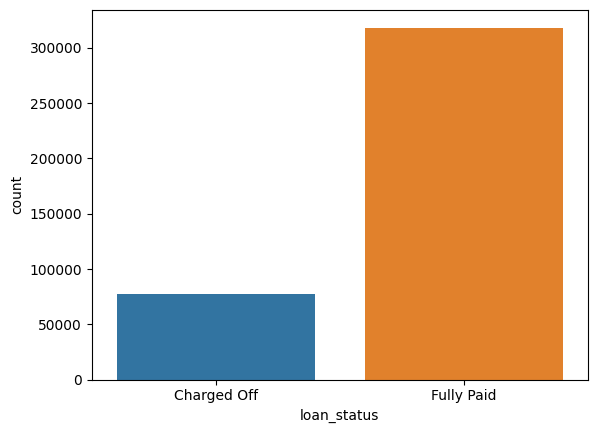

In [428]:
sns.countplot(data=loan_data, x='loan_status', order=np.sort(loan_data['loan_status'].unique()))
plt.show()

==> we have imbalance in target variable

- loan_amnt : The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.

In [429]:
loan_data.groupby(by='loan_status')['loan_amnt'].describe().round(1)

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,77673.0,15126.3,8505.1,1000.0,8525.0,14000.0,20000.0,40000.0
Fully Paid,318357.0,13866.9,8302.3,500.0,7500.0,12000.0,19225.0,40000.0


In [430]:
loan_data['loan_amnt'].value_counts().reset_index().rename(columns={"index": "loan_amnt", "loan_amnt": "count"}).head(5)

,loan_amnt,count
0,10000.0,27668
1,12000.0,21366
2,15000.0,19903
3,20000.0,18969
4,35000.0,14576


In [431]:
loan_data['loan_amnt'].value_counts().reset_index().rename(columns={"index": "loan_amnt", "loan_amnt": "count"}).tail(5)

,loan_amnt,count
1392,36225.0,1
1393,950.0,1
1394,37800.0,1
1395,30050.0,1
1396,725.0,1


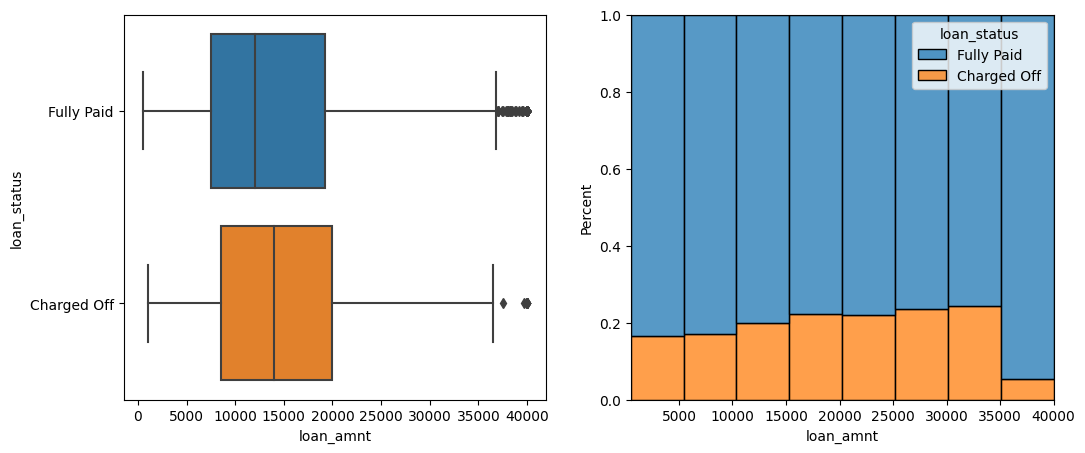

In [432]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.boxplot(data=loan_data, x='loan_amnt', y='loan_status')
plt.subplot(1,2,2)
sns.histplot(data=loan_data, x="loan_amnt", bins=8, hue='loan_status', stat='percent', multiple='fill')
plt.show()

==> people borrowing loan_amount > 35k shows less chance of charged off loan status

- term : The number of payments on the loan. Values are in months and can be either 36 or 60

In [433]:
loan_data.groupby(by='loan_status')['term'].describe().round(1)

,count,unique,top,freq
loan_status,,,,
Charged Off,77673,2,36 months,47640
Fully Paid,318357,2,36 months,254365


In [434]:
(pd.crosstab(index=loan_data['loan_status'], columns=loan_data['term'], normalize='columns', margins=True)*100).round(1)

term,36 months,60 months,All
loan_status,,,
Charged Off,15.8,31.9,19.6
Fully Paid,84.2,68.1,80.4


In [435]:
(pd.crosstab(index=loan_data['loan_status'], columns=loan_data['term'], normalize='index', margins=True)*100).round(1)

term,36 months,60 months
loan_status,,
Charged Off,61.3,38.7
Fully Paid,79.9,20.1
All,76.3,23.7


In [436]:
(pd.crosstab(index=loan_data['loan_status'], columns=loan_data['term'], normalize='all', margins=True)*100).round(1)

term,36 months,60 months,All
loan_status,,,
Charged Off,12.0,7.6,19.6
Fully Paid,64.2,16.2,80.4
All,76.3,23.7,100.0


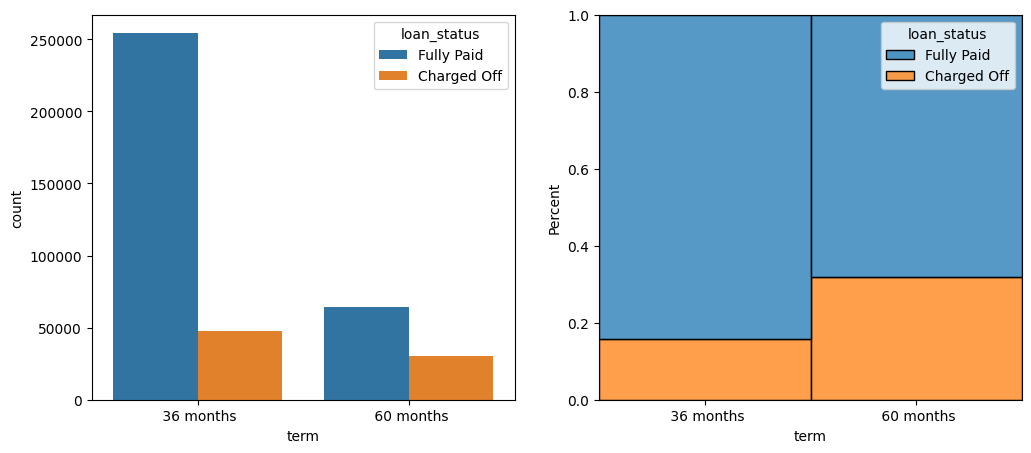

In [437]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.countplot(data=loan_data, x='term', hue='loan_status', order=np.sort(loan_data['term'].unique()))
plt.subplot(1,2,2)
sns.histplot(data=loan_data, x="term", hue="loan_status", stat="percent", multiple="fill")
plt.show()

==> chances of being charged off in 60 months term is high compared to 36 months term  

- int_rate : Interest Rate on the loan

In [438]:
loan_data.groupby(by='loan_status')['int_rate'].describe().round(1)

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,77673.0,15.9,4.4,5.3,13.0,15.6,18.6,31.0
Fully Paid,318357.0,13.1,4.3,5.3,9.9,13.0,15.6,31.0


In [439]:
loan_data['int_rate'].value_counts().reset_index().rename(columns={"index": "int_rate", "int_rate": "count"}).head(5)

,int_rate,count
0,10.99,12411
1,12.99,9632
2,15.61,9350
3,11.99,8582
4,8.90,8019


In [440]:
loan_data['int_rate'].value_counts().reset_index().rename(columns={"index": "int_rate", "int_rate": "count"}).tail(5)

,int_rate,count
561,14.28,1
562,18.72,1
563,18.36,1
564,30.84,1
565,24.59,1


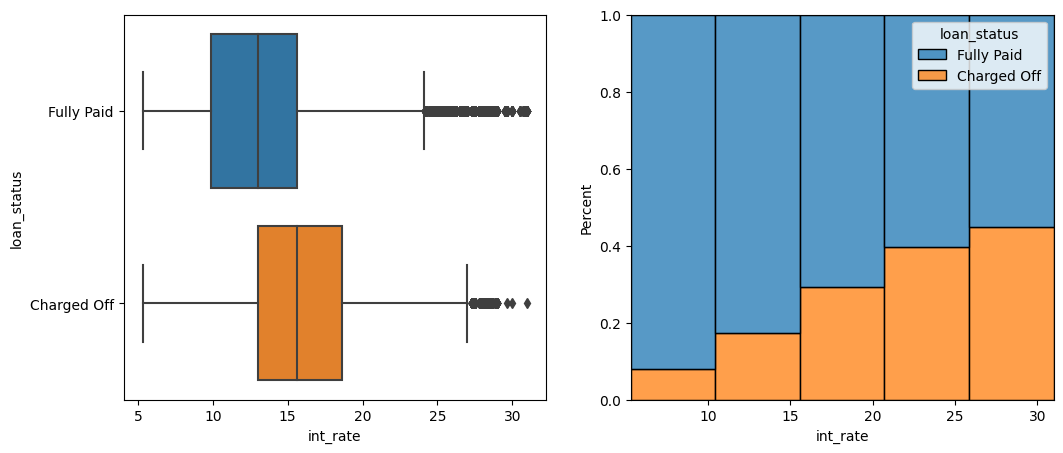

In [441]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.boxplot(data=loan_data, x='int_rate', y='loan_status')
plt.subplot(1,2,2)
sns.histplot(data=loan_data, x="int_rate", bins=5, hue='loan_status', stat='percent', multiple='fill')
plt.show()

==> As interest rate increases so the chances of charged off increases

- installment : The monthly payment owed by the borrower if the loan originates

In [442]:
loan_data.groupby(by='loan_status')['installment'].describe().round(1)

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,77673.0,452.7,249.1,21.6,274.9,399.1,585.7,1527.0
Fully Paid,318357.0,426.8,250.9,16.1,244.5,369.5,562.9,1533.8


In [443]:
loan_data['installment'].value_counts().reset_index().rename(columns={"index": "installment", "installment": "count"}).head(5)

,installment,count
0,327.34,968
1,332.10,791
2,491.01,736
3,336.90,686
4,392.81,683


In [444]:
loan_data['installment'].value_counts().reset_index().rename(columns={"index": "installment", "installment": "count"}).tail(5)

,installment,count
55701,364.37,1
55702,1015.29,1
55703,398.04,1
55704,544.94,1
55705,572.44,1


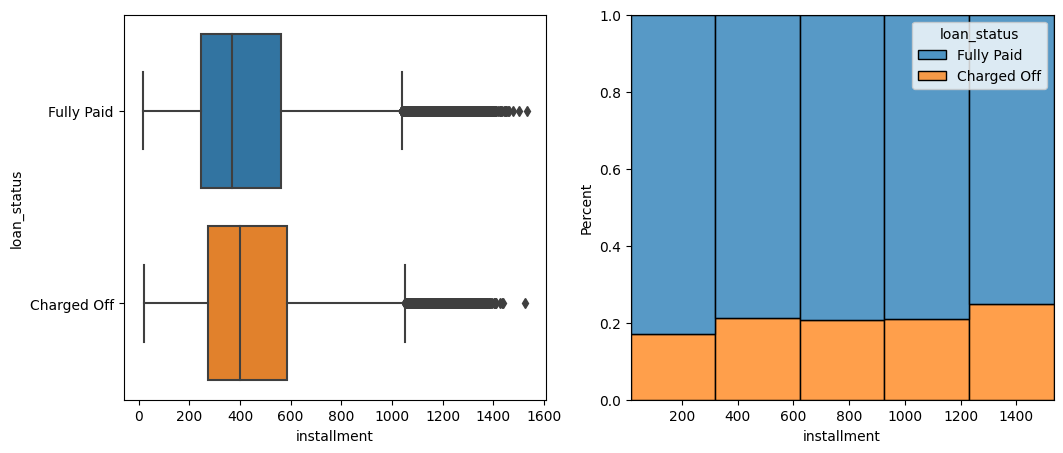

In [445]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.boxplot(data=loan_data, x='installment', y='loan_status')
plt.subplot(1,2,2)
sns.histplot(data=loan_data, x="installment", bins=5, hue='loan_status', stat='percent', multiple='fill')
plt.show()

==> By looking at the installment we are unable to comment on loan status

- grade : LoanTap assigned loan grade

In [446]:
loan_data.groupby(by='loan_status')['grade'].describe().round(1)

,count,unique,top,freq
loan_status,,,,
Charged Off,77673,7,C,22449
Fully Paid,318357,7,B,101431


In [447]:
(pd.crosstab(index=loan_data['loan_status'], columns=loan_data['grade'], normalize='columns', margins=True)*100).round(1)

grade,A,B,C,D,E,F,G,All
loan_status,,,,,,,,
Charged Off,6.3,12.6,21.2,28.9,37.4,42.8,47.8,19.6
Fully Paid,93.7,87.4,78.8,71.1,62.6,57.2,52.2,80.4


In [448]:
(pd.crosstab(index=loan_data['loan_status'], columns=loan_data['grade'], normalize='index', margins=True)*100).round(1)

grade,A,B,C,D,E,F,G
loan_status,,,,,,,
Charged Off,5.2,18.8,28.9,23.6,15.1,6.5,1.9
Fully Paid,18.9,31.9,26.2,14.2,6.2,2.1,0.5
All,16.2,29.3,26.8,16.0,8.0,3.0,0.8


In [449]:
(pd.crosstab(index=loan_data['loan_status'], columns=loan_data['grade'], normalize='all', margins=True)*100).round(1)

grade,A,B,C,D,E,F,G,All
loan_status,,,,,,,,
Charged Off,1.0,3.7,5.7,4.6,3.0,1.3,0.4,19.6
Fully Paid,15.2,25.6,21.1,11.4,5.0,1.7,0.4,80.4
All,16.2,29.3,26.8,16.0,8.0,3.0,0.8,100.0


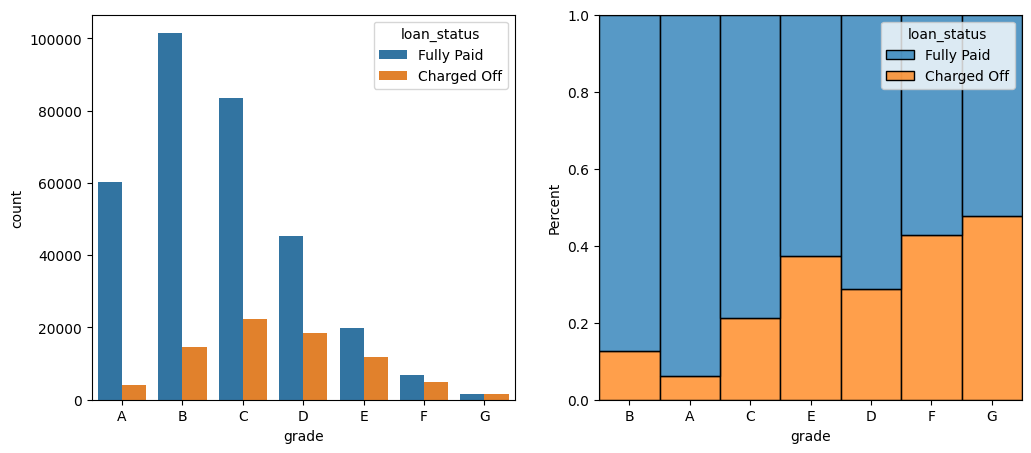

In [450]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.countplot(data=loan_data, x='grade', hue='loan_status', order=np.sort(loan_data['grade'].unique()))
plt.subplot(1,2,2)
sns.histplot(data=loan_data, x="grade", hue="loan_status", stat="percent", multiple="fill")
plt.show()

==> chance of charged off against grade follow in the order of G > F > E > D > C > B > A

- sub_grade : LoanTap assigned loan subgrade

In [451]:
loan_data.groupby(by='loan_status')['sub_grade'].describe().round(1)

,count,unique,top,freq
loan_status,,,,
Charged Off,77673,35,C4,4773
Fully Paid,318357,35,B3,23367


In [452]:
loan_data['sub_grade'].value_counts().reset_index().rename(columns={"index": "sub_grade", "sub_grade": "count"}).head(5)

,sub_grade,count
0,B3,26655
1,B4,25601
2,C1,23662
3,C2,22580
4,B2,22495


In [453]:
loan_data['sub_grade'].value_counts().reset_index().rename(columns={"index": "sub_grade", "sub_grade": "count"}).tail(5)

,sub_grade,count
30,G1,1058
31,G2,754
32,G3,552
33,G4,374
34,G5,316


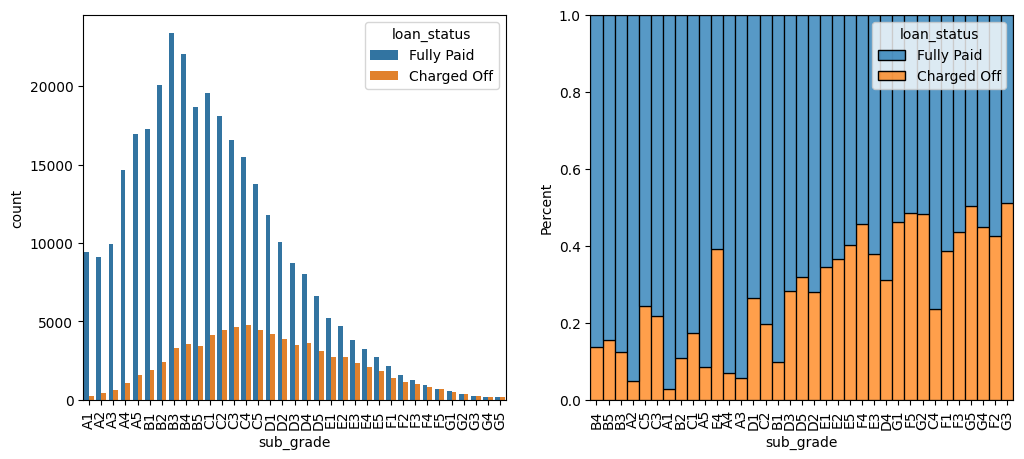

In [454]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
fig = sns.countplot(data=loan_data, x='sub_grade', hue='loan_status', order=np.sort(loan_data['sub_grade'].unique()))
fig.set_xticklabels(fig.get_xticklabels(), rotation=90);
plt.subplot(1,2,2)
fig1 = sns.histplot(data=loan_data, x="sub_grade", hue="loan_status", stat="percent", multiple="fill")
fig1.set_xticklabels(fig1.get_xticklabels(), rotation=90);
plt.show()

==> there are low chances of being charged off in sub categories of A & B compared to others

- emp_title :The job title supplied by the Borrower when applying for the loan

In [455]:
loan_data.groupby(by='loan_status')['emp_title'].describe().round(1)

,count,unique,top,freq
loan_status,,,,
Charged Off,71730,40057,Manager,929
Fully Paid,301373,145235,Teacher,3532


In [456]:
loan_data['emp_title'].value_counts()[:10]

Teacher             4389
Manager             4250
Registered Nurse    1856
RN                  1846
Supervisor          1830
Sales               1638
Project Manager     1505
Owner               1410
Driver              1339
Office Manager      1218
Name: emp_title, dtype: int64

<AxesSubplot: >

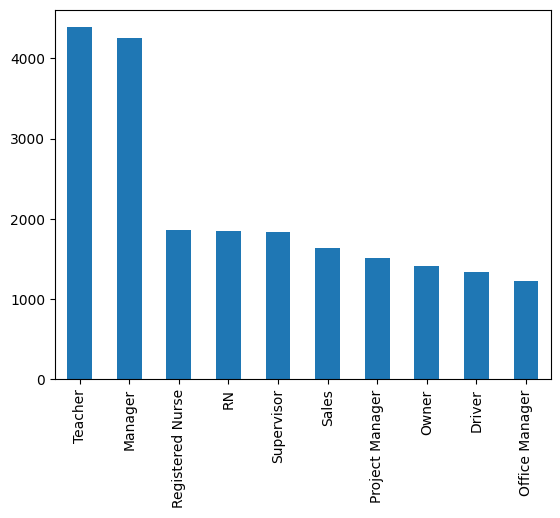

In [457]:
loan_data['emp_title'].value_counts()[:10].plot(kind='bar')

==> 'Teacher' and 'Manager' are most afforded loan borrowers 

- emp_length : Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years

In [458]:
loan_data.groupby(by='loan_status')['emp_length'].describe().round(1)

,count,unique,top,freq
loan_status,,,,
Charged Off,72635,11,10+ years,23215
Fully Paid,305094,11,10+ years,102826


In [459]:
(pd.crosstab(index=loan_data['loan_status'], columns=loan_data['emp_length'], normalize='columns', margins=True)*100).round(1)

emp_length,1 year,10+ years,2 years,3 years,4 years,5 years,6 years,7 years,8 years,9 years,< 1 year,All
loan_status,,,,,,,,,,,,
Charged Off,19.9,18.4,19.3,19.5,19.2,19.2,18.9,19.5,20.0,20.0,20.7,19.2
Fully Paid,80.1,81.6,80.7,80.5,80.8,80.8,81.1,80.5,80.0,80.0,79.3,80.8


In [460]:
(pd.crosstab(index=loan_data['loan_status'], columns=loan_data['emp_length'], normalize='index', margins=True)*100).round(1)

emp_length,1 year,10+ years,2 years,3 years,4 years,5 years,6 years,7 years,8 years,9 years,< 1 year
loan_status,,,,,,,,,,,
Charged Off,7.1,32.0,9.5,8.5,6.3,7.0,5.4,5.6,5.3,4.2,9.0
Fully Paid,6.8,33.7,9.5,8.4,6.3,7.0,5.5,5.5,5.0,4.0,8.2
All,6.9,33.4,9.5,8.4,6.3,7.0,5.5,5.5,5.1,4.1,8.4


In [461]:
(pd.crosstab(index=loan_data['loan_status'], columns=loan_data['emp_length'], normalize='all', margins=True)*100).round(1)

emp_length,1 year,10+ years,2 years,3 years,4 years,5 years,6 years,7 years,8 years,9 years,< 1 year,All
loan_status,,,,,,,,,,,,
Charged Off,1.4,6.1,1.8,1.6,1.2,1.3,1.0,1.1,1.0,0.8,1.7,19.2
Fully Paid,5.5,27.2,7.7,6.7,5.1,5.7,4.5,4.4,4.1,3.2,6.7,80.8
All,6.9,33.4,9.5,8.4,6.3,7.0,5.5,5.5,5.1,4.1,8.4,100.0


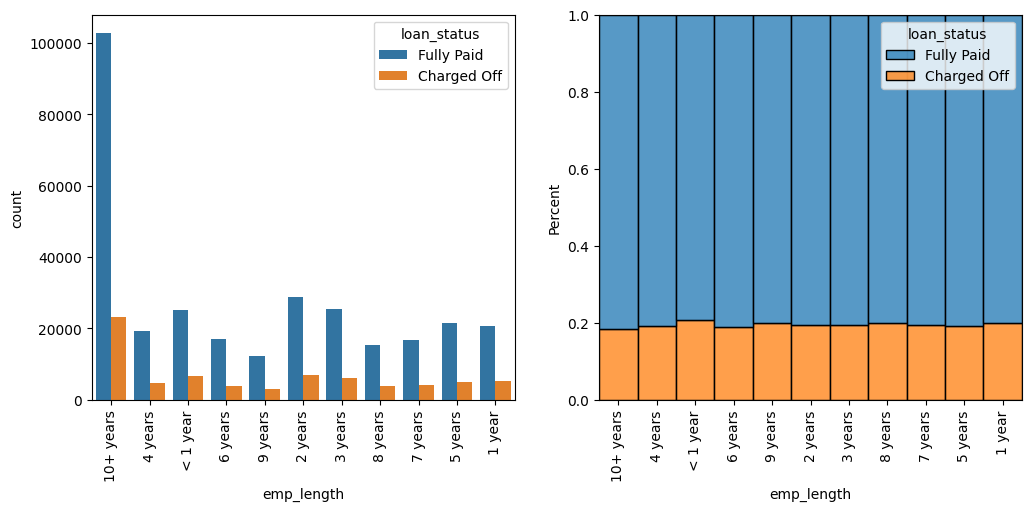

In [462]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
fig = sns.countplot(data=loan_data, x='emp_length', hue='loan_status')
fig.set_xticklabels(fig.get_xticklabels(), rotation=90);
plt.subplot(1,2,2)
fig1 = sns.histplot(data=loan_data, x="emp_length", hue="loan_status", stat="percent", multiple="fill")
fig1.set_xticklabels(fig1.get_xticklabels(), rotation=90);
plt.show()

==> 10+ years of experience employees are most afforded borrowers and by looking at the emp_length value it is hard to comment on loan status 

- home_ownership : The home ownership status provided by the borrower during registration or obtained from the credit report

In [463]:
loan_data['home_ownership'].value_counts()

MORTGAGE    198348
RENT        159790
OWN          37746
OTHER          112
NONE            31
ANY              3
Name: home_ownership, dtype: int64

In [464]:
#combining minority classes into other
loan_data.loc[(loan_data.home_ownership == 'ANY') | (loan_data.home_ownership == 'NONE'), 'home_ownership'] = 'OTHER'  
loan_data.home_ownership.value_counts()

MORTGAGE    198348
RENT        159790
OWN          37746
OTHER          146
Name: home_ownership, dtype: int64

In [465]:
loan_data.groupby(by='loan_status')['home_ownership'].describe().round(1)

,count,unique,top,freq
loan_status,,,,
Charged Off,77673,4,RENT,36212
Fully Paid,318357,4,MORTGAGE,164716


In [466]:
(pd.crosstab(index=loan_data['loan_status'], columns=loan_data['home_ownership'], normalize='columns', margins=True)*100).round(1)

home_ownership,MORTGAGE,OTHER,OWN,RENT,All
loan_status,,,,,
Charged Off,17.0,15.8,20.7,22.7,19.6
Fully Paid,83.0,84.2,79.3,77.3,80.4


In [467]:
(pd.crosstab(index=loan_data['loan_status'], columns=loan_data['home_ownership'], normalize='index', margins=True)*100).round(1)

home_ownership,MORTGAGE,OTHER,OWN,RENT
loan_status,,,,
Charged Off,43.3,0.0,10.0,46.6
Fully Paid,51.7,0.0,9.4,38.8
All,50.1,0.0,9.5,40.3


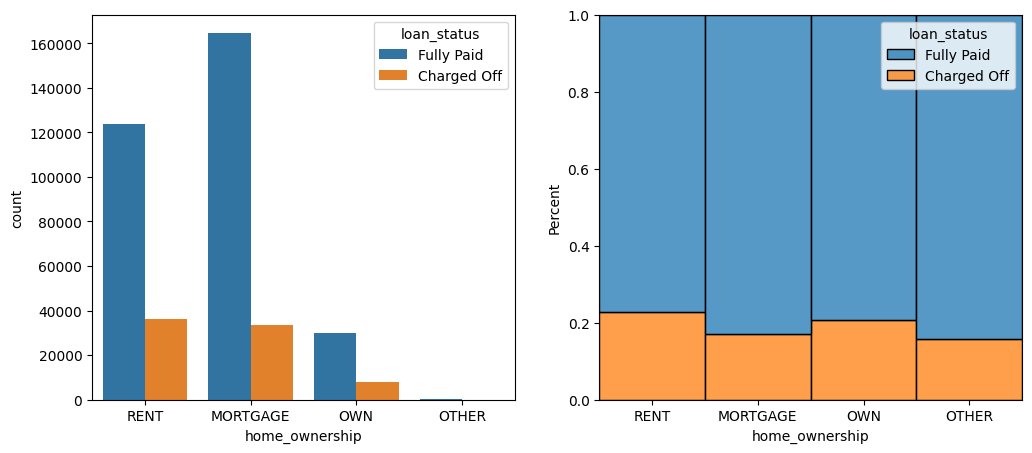

In [468]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.countplot(data=loan_data, x='home_ownership', hue='loan_status')
plt.subplot(1,2,2)
sns.histplot(data=loan_data, x="home_ownership", hue="loan_status", stat="percent", multiple="fill")
plt.show()

==> The majority of people have home ownership as Mortgage and Rent and by looking at the home_ownership it is hard to comment on loan status

- annual_inc : The self-reported annual income provided by the borrower during registration

In [469]:
loan_data.groupby(by='loan_status')['annual_inc'].describe().round(1)

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,77673.0,67535.5,58303.5,0.0,42000.0,59000.0,80000.0,8706582.0
Fully Paid,318357.0,75830.0,62316.0,600.0,46050.5,65000.0,90000.0,7600000.0


In [470]:
loan_data['annual_inc'].value_counts().reset_index().rename(columns={"index": "annual_inc", "annual_inc": "count"}).head(10)

,annual_inc,count
0,60000.0,15313
1,50000.0,13303
2,65000.0,11333
3,70000.0,10674
4,40000.0,10629
5,45000.0,10114
6,80000.0,9971
7,75000.0,9850
8,55000.0,9195
9,90000.0,7573


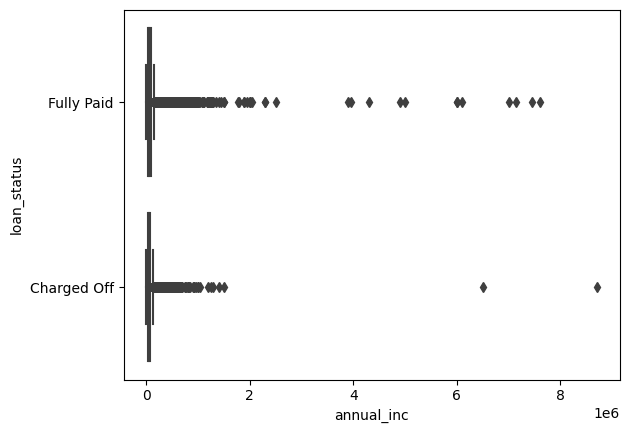

In [471]:
sns.boxplot(data=loan_data, x='annual_inc', y='loan_status')
plt.show()

In [472]:
data = loan_data.loc[(loan_data['annual_inc']<100000) & (20000<loan_data['annual_inc']), ['annual_inc', 'loan_status']]

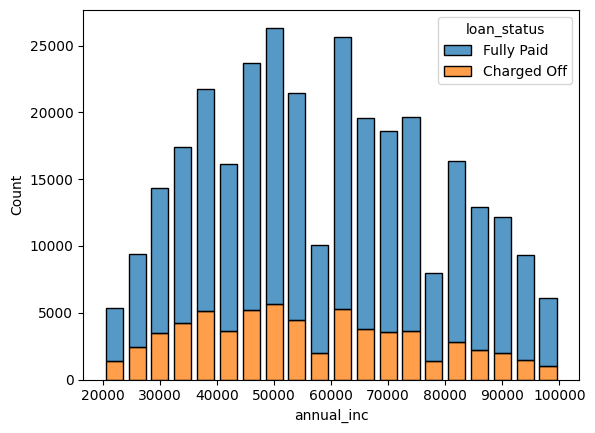

In [473]:
sns.histplot(data=data, x='annual_inc', hue='loan_status', bins=20, multiple='stack', shrink=0.75)
plt.show()

==> Majority of people have annual income below 1 lac

- verification_status : Indicates if income was verified by LoanTap, not verified, or if the income source was verified

In [474]:
loan_data.groupby(by='loan_status')['verification_status'].describe().round(1)

,count,unique,top,freq
loan_status,,,,
Charged Off,77673,3,Verified,31152
Fully Paid,318357,3,Verified,108411


In [475]:
(pd.crosstab(index=loan_data['loan_status'], columns=loan_data['verification_status'], normalize='columns', margins=True)*100).round(1)

verification_status,Not Verified,Source Verified,Verified,All
loan_status,,,,
Charged Off,14.6,21.5,22.3,19.6
Fully Paid,85.4,78.5,77.7,80.4


In [476]:
(pd.crosstab(index=loan_data['loan_status'], columns=loan_data['verification_status'], normalize='index', margins=True)*100).round(1)

verification_status,Not Verified,Source Verified,Verified
loan_status,,,
Charged Off,23.6,36.3,40.1
Fully Paid,33.5,32.4,34.1
All,31.6,33.2,35.2


In [477]:
(pd.crosstab(index=loan_data['loan_status'], columns=loan_data['verification_status'], normalize='all', margins=True)*100).round(1)

verification_status,Not Verified,Source Verified,Verified,All
loan_status,,,,
Charged Off,4.6,7.1,7.9,19.6
Fully Paid,27.0,26.1,27.4,80.4
All,31.6,33.2,35.2,100.0


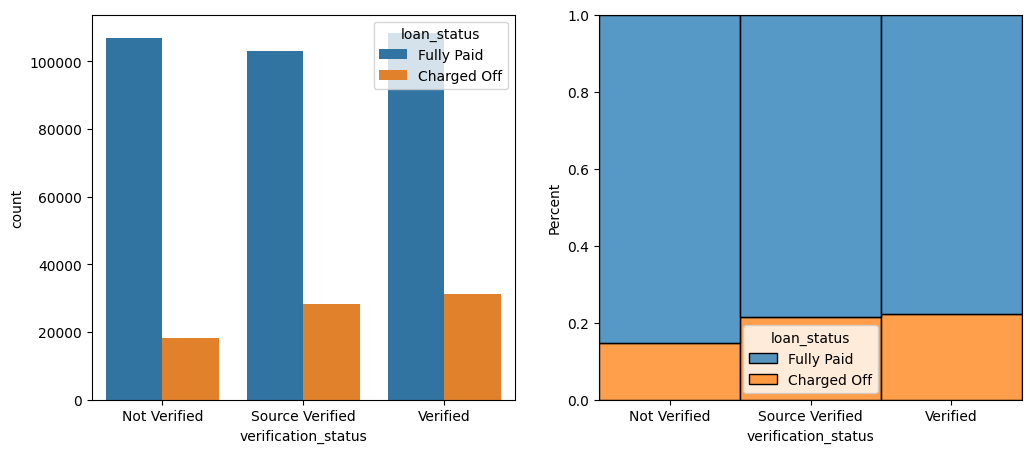

In [478]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.countplot(data=loan_data, x='verification_status', hue='loan_status')
plt.subplot(1,2,2)
sns.histplot(data=loan_data, x="verification_status", hue="loan_status", stat="percent", multiple="fill")
plt.show()

==> By looking at the verification_status it is hard to comment on loan status

- issue_d : The month which the loan was funded

In [479]:
loan_data['issue_d'] = pd.to_datetime(loan_data['issue_d'])

In [480]:
loan_data.groupby(by='loan_status')['issue_d'].describe().round(1)

,count,unique,top,freq,first,last
loan_status,,,,,,
Charged Off,77673,111,2014-10-01 00:00:00,3728,2007-08-01 00:00:00,2016-10-01 00:00:00
Fully Paid,318357,115,2014-10-01 00:00:00,11118,2007-06-01 00:00:00,2016-12-01 00:00:00


In [481]:
loan_data['issue_d'].value_counts()[:10]

2014-10-01    14846
2014-07-01    12609
2015-01-01    11705
2013-12-01    10618
2013-11-01    10496
2015-07-01    10270
2013-10-01    10047
2014-01-01     9705
2015-04-01     9470
2013-09-01     9179
Name: issue_d, dtype: int64

In [482]:
years = loan_data['issue_d'].dt.year.values
data = pd.DataFrame({'issue_d':years, 'loan_status':loan_data['loan_status'].values})
data

,issue_d,loan_status
0,2015,Fully Paid
1,2015,Fully Paid
2,2015,Fully Paid
3,2014,Fully Paid
4,2013,Charged Off
...,...,...
396025,2015,Fully Paid
396026,2015,Fully Paid
396027,2013,Fully Paid
396028,2012,Fully Paid


In [483]:
np.sort(data['issue_d'].unique())

array([2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016],
      dtype=int64)

In [484]:
data['issue_d'] = data['issue_d'].astype('category')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   issue_d      396030 non-null  category
 1   loan_status  396030 non-null  object  
dtypes: category(1), object(1)
memory usage: 3.4+ MB


In [485]:
data.groupby(by='loan_status')['issue_d'].describe()

,count,unique,top,freq
loan_status,,,,
Charged Off,77673,10,2014,23772
Fully Paid,318357,10,2013,82290


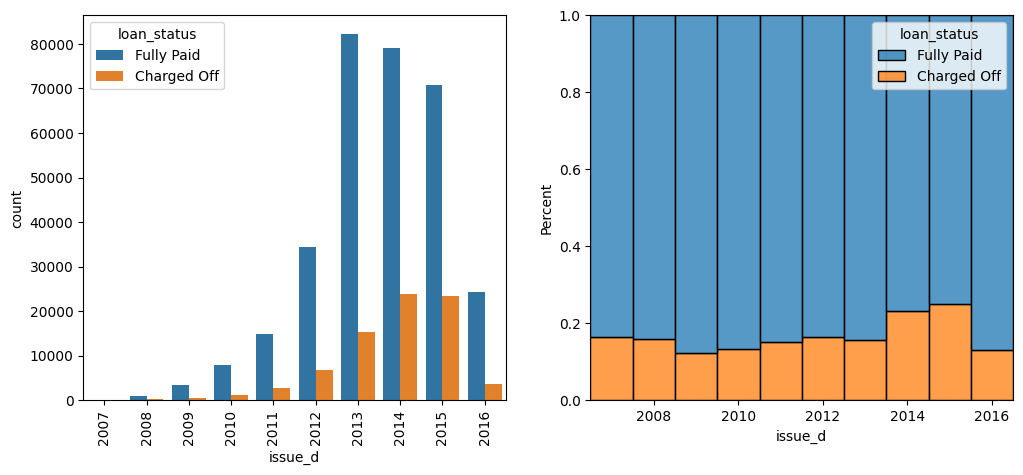

In [486]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
fig = sns.countplot(data=data, x="issue_d", hue="loan_status")
fig.set_xticklabels(fig.get_xticklabels(), rotation=90);
plt.subplot(1,2,2)
sns.histplot(data=data, x="issue_d", hue="loan_status", stat="percent", multiple="fill")
plt.show()

==> By looking at the issue_d value it is hard to comment on loan status

- purpose : A category provided by the borrower for the loan request

In [487]:
loan_data.groupby(by='loan_status')['purpose'].describe().round(1)

,count,unique,top,freq
loan_status,,,,
Charged Off,77673,14,debt_consolidation,48640
Fully Paid,318357,14,debt_consolidation,185867


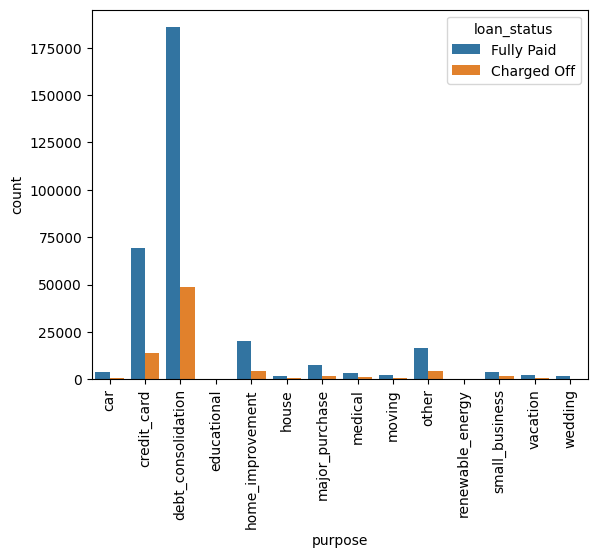

In [488]:
fig = sns.countplot(data=loan_data, x="purpose", hue="loan_status", order=np.sort(loan_data['purpose'].unique()))
fig.set_xticklabels(fig.get_xticklabels(), rotation=90);
plt.show()

==> Most common purpose for borrowing loan is debt consolidation and credit card

- title : The loan title provided by the borrower

In [489]:
loan_data['title'] = loan_data['title'].str.lower()

In [490]:
loan_data['title'].value_counts()[:30]

debt consolidation           168108
credit card refinancing       51781
home improvement              17117
other                         12993
consolidation                  5583
major purchase                 4998
debt consolidation loan        3513
business                       3017
medical expenses               2820
credit card consolidation      2638
personal loan                  2460
car financing                  2160
credit card payoff             1904
consolidation loan             1887
vacation                       1866
credit card refinance          1832
moving and relocation          1693
consolidate                    1528
personal                       1465
home buying                    1196
loan                           1150
payoff                         1035
credit cards                   1030
freedom                         934
debt                            933
my loan                         897
credit card loan                879
credit card                 

In [491]:
loan_data.loc[loan_data['title'].str.contains('debt', regex=True, na=False), 'title'].nunique()

7318

In [492]:
loan_data.groupby(by='loan_status')['title'].describe().round(1)

,count,unique,top,freq
loan_status,,,,
Charged Off,77344,8121,debt consolidation,37625
Fully Paid,316931,36020,debt consolidation,130483


In [493]:
loan_data['title'].value_counts()[:10]

debt consolidation           168108
credit card refinancing       51781
home improvement              17117
other                         12993
consolidation                  5583
major purchase                 4998
debt consolidation loan        3513
business                       3017
medical expenses               2820
credit card consolidation      2638
Name: title, dtype: int64

- dti : A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LoanTap loan, divided by the borrower’s self-reported monthly income

In [494]:
loan_data.groupby(by='loan_status')['dti'].describe().round(1)

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,77673.0,19.7,36.8,0.0,13.3,19.3,25.6,9999.0
Fully Paid,318357.0,16.8,8.5,0.0,10.9,16.3,22.3,1622.0


In [495]:
loan_data['dti'].value_counts().head(10)

0.0     313
14.4    310
19.2    302
16.8    301
18.0    300
20.4    296
12.0    293
13.2    291
21.6    270
15.6    266
Name: dti, dtype: int64

In [496]:
data = loan_data.loc[loan_data['dti']<50, ['dti', 'loan_status']]

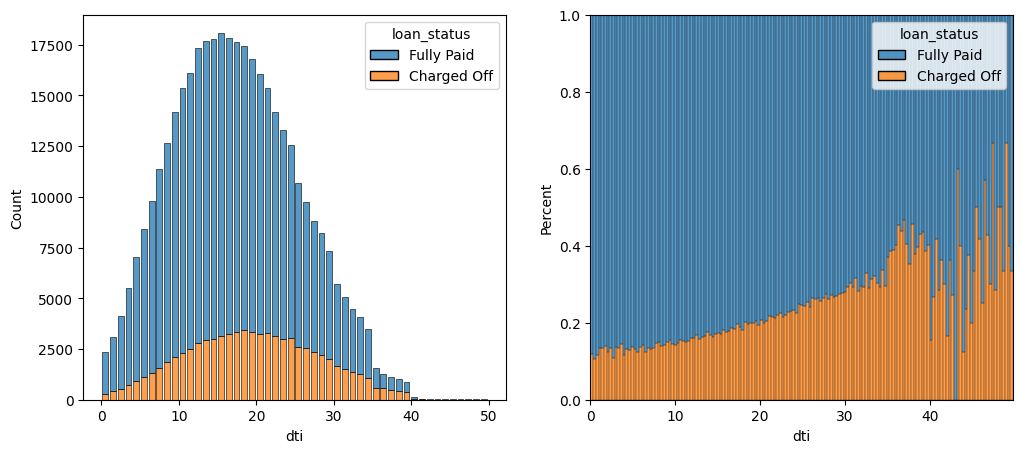

In [497]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(data=data, x='dti', hue='loan_status', bins=50, multiple='stack', shrink=0.75)
plt.subplot(1,2,2)
sns.histplot(data=data, x='dti', hue='loan_status', stat='percent', multiple='fill')
plt.show()

==> As dti increases so the chances of charged off also increases

- earliest_cr_line :The month the borrower's earliest reported credit line was opened

In [498]:
loan_data.groupby(by='loan_status')['earliest_cr_line'].describe().round(1)

,count,unique,top,freq
loan_status,,,,
Charged Off,77673,626,Aug-2001,573
Fully Paid,318357,670,Oct-2000,2466


In [499]:
loan_data['earliest_cr_line'].value_counts().head(10)

Oct-2000    3017
Aug-2000    2935
Oct-2001    2896
Aug-2001    2884
Nov-2000    2736
Oct-1999    2726
Nov-1999    2700
Sep-2000    2691
Oct-2002    2640
Aug-2002    2599
Name: earliest_cr_line, dtype: int64

- open_acc : The number of open credit lines in the borrower's credit file

In [500]:
loan_data['open_acc'] = loan_data['open_acc'].astype('int')

In [501]:
loan_data.groupby(by='loan_status')['open_acc'].describe().round(1)

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,77673.0,11.6,5.3,0.0,8.0,11.0,14.0,76.0
Fully Paid,318357.0,11.2,5.1,0.0,8.0,10.0,14.0,90.0


In [502]:
data = loan_data.loc[loan_data['open_acc']<=30, ['open_acc', 'loan_status']]

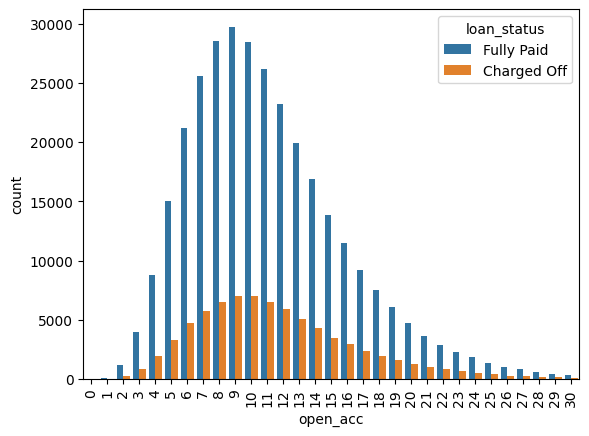

In [503]:
fig = sns.countplot(data=data, x='open_acc', hue='loan_status')
fig.set_xticklabels(fig.get_xticklabels(), rotation=90);
plt.show()

- pub_rec : Number of derogatory public records

In [504]:
loan_data['pub_rec'] = loan_data['pub_rec'].astype('int')

In [505]:
loan_data.groupby(by='loan_status')['pub_rec'].describe().round(1)

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,77673.0,0.2,0.6,0.0,0.0,0.0,0.0,86.0
Fully Paid,318357.0,0.2,0.5,0.0,0.0,0.0,0.0,24.0


In [506]:
(pd.crosstab(index=loan_data['loan_status'], columns=loan_data['pub_rec']))

pub_rec,0,1,2,3,4,5,6,7,8,9,10,11,12,13,15,17,19,24,40,86
loan_status,,,,,,,,,,,,,,,,,,,,
Charged Off,65339,10469,1254,340,145,56,31,16,6,5,2,1,4,1,0,0,2,0,1,1
Fully Paid,272933,39270,4222,1181,382,181,91,40,28,7,9,7,0,3,1,1,0,1,0,0


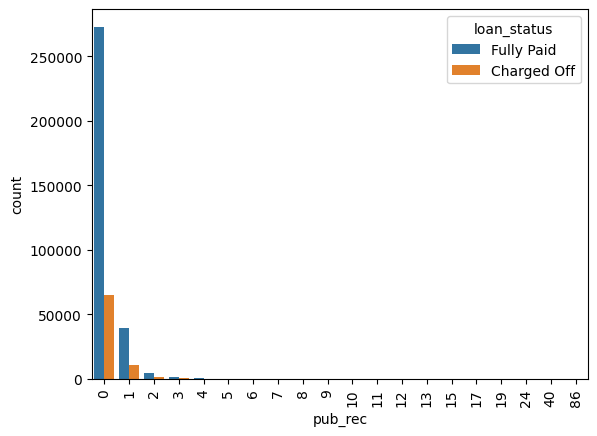

In [507]:
fig = sns.countplot(data=loan_data, x='pub_rec', hue='loan_status')
fig.set_xticklabels(fig.get_xticklabels(), rotation=90);
plt.show()

==> Number of derogatory public records increase so the chances of charged off increase

- revol_bal : Total credit revolving balance

In [508]:
loan_data['revol_bal'] = loan_data['revol_bal'].astype('int')

In [509]:
loan_data.groupby(by='loan_status')['revol_bal'].describe().round(1)

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,77673.0,15390.5,18203.4,0.0,6150.0,11277.0,19485.0,1030826.0
Fully Paid,318357.0,15955.3,21132.2,0.0,5992.0,11158.0,19657.0,1743266.0


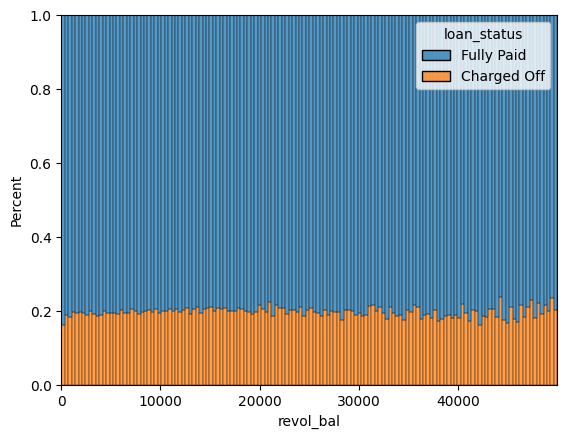

In [510]:
data = loan_data.loc[loan_data['revol_bal']<50000]
sns.histplot(data=data, x='revol_bal', hue='loan_status', stat='percent', multiple='fill')
plt.show()

- revol_util : Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit

In [511]:
loan_data.groupby(by='loan_status')['revol_util'].describe().round(1)

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,77610.0,57.9,23.5,0.0,41.2,59.3,76.2,148.0
Fully Paid,318144.0,52.8,24.6,0.0,34.6,53.7,72.0,892.3


In [512]:
loan_data['revol_util'].value_counts().head(10)

0.0     2213
53.0     752
60.0     739
61.0     734
55.0     730
54.0     725
62.0     721
47.0     720
57.0     719
58.0     717
Name: revol_util, dtype: int64

In [513]:
loan_data['revol_util'].value_counts().tail(10)

129.50    1
10.61     1
114.00    1
26.33     1
10.08     1
892.30    1
110.10    1
123.00    1
49.63     1
128.10    1
Name: revol_util, dtype: int64

- total_acc : The total number of credit lines currently in the borrower's credit file

In [514]:
loan_data['total_acc'] = loan_data['total_acc'].astype('int')

In [515]:
loan_data.groupby(by='loan_status')['total_acc'].describe().round(1)

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,77673.0,25.0,11.9,2.0,16.0,23.0,32.0,151.0
Fully Paid,318357.0,25.5,11.9,2.0,17.0,24.0,32.0,150.0


In [516]:
loan_data['total_acc'].value_counts().head(10)

21    14280
22    14260
20    14228
23    13923
24    13878
19    13876
18    13710
17    13495
25    13225
26    12799
Name: total_acc, dtype: int64

In [517]:
loan_data['total_acc'].value_counts().tail(10)

115    1
108    1
118    1
151    1
124    1
110    1
129    1
135    1
104    1
103    1
Name: total_acc, dtype: int64

- initial_list_status : The initial listing status of the loan. Possible values are – W, F

In [518]:
loan_data.groupby(by='loan_status')['initial_list_status'].describe().round(1)

,count,unique,top,freq
loan_status,,,,
Charged Off,77673,2,f,45961
Fully Paid,318357,2,f,192105


In [519]:
(pd.crosstab(index=loan_data['loan_status'], columns=loan_data['initial_list_status'], normalize='columns', margins=True)*100).round(1)

initial_list_status,f,w,All
loan_status,,,
Charged Off,19.3,20.1,19.6
Fully Paid,80.7,79.9,80.4


In [520]:
(pd.crosstab(index=loan_data['loan_status'], columns=loan_data['initial_list_status'], normalize='index', margins=True)*100).round(1)

initial_list_status,f,w
loan_status,,
Charged Off,59.2,40.8
Fully Paid,60.3,39.7
All,60.1,39.9


In [521]:
(pd.crosstab(index=loan_data['loan_status'], columns=loan_data['initial_list_status'], normalize='all', margins=True)*100).round(1)

initial_list_status,f,w,All
loan_status,,,
Charged Off,11.6,8.0,19.6
Fully Paid,48.5,31.9,80.4
All,60.1,39.9,100.0


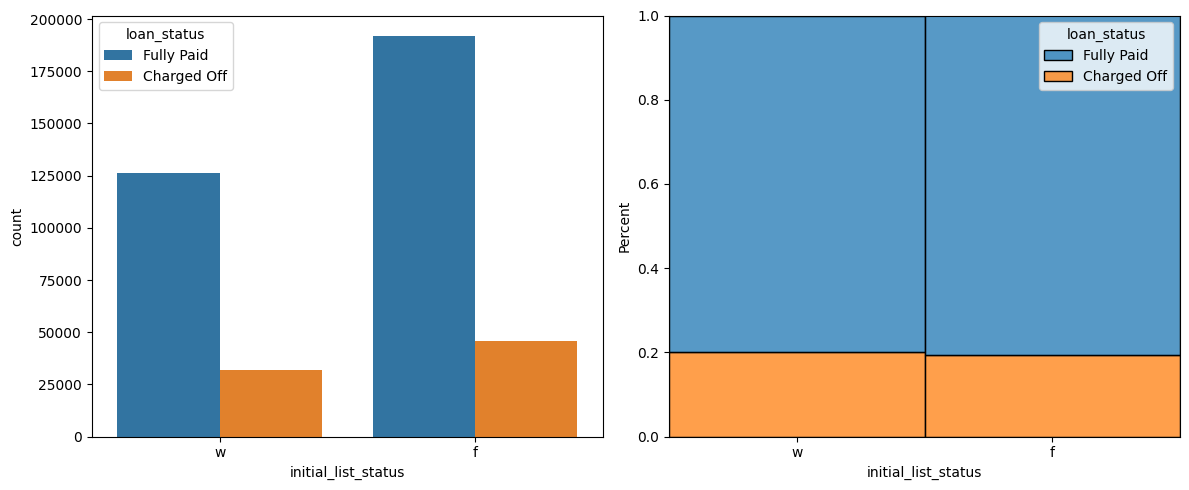

In [522]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.countplot(data=loan_data, x='initial_list_status', hue='loan_status')
plt.subplot(1,2,2)
sns.histplot(data=loan_data, x='initial_list_status', hue='loan_status', stat='percent', multiple='fill')
plt.tight_layout()
plt.show()

- application_type : Indicates whether the loan is an individual application or a joint application with two co-borrowers

In [523]:
loan_data['application_type'].value_counts()

INDIVIDUAL    395319
JOINT            425
DIRECT_PAY       286
Name: application_type, dtype: int64

In [524]:
(pd.crosstab(index=loan_data['loan_status'], columns=loan_data['application_type'], normalize='columns', margins=True)*100).round(1)

application_type,DIRECT_PAY,INDIVIDUAL,JOINT,All
loan_status,,,,
Charged Off,35.7,19.6,12.7,19.6
Fully Paid,64.3,80.4,87.3,80.4


In [525]:
(pd.crosstab(index=loan_data['loan_status'], columns=loan_data['application_type'], normalize='all', margins=True)*100).round(1)

application_type,DIRECT_PAY,INDIVIDUAL,JOINT,All
loan_status,,,,
Charged Off,0.0,19.6,0.0,19.6
Fully Paid,0.0,80.2,0.1,80.4
All,0.1,99.8,0.1,100.0


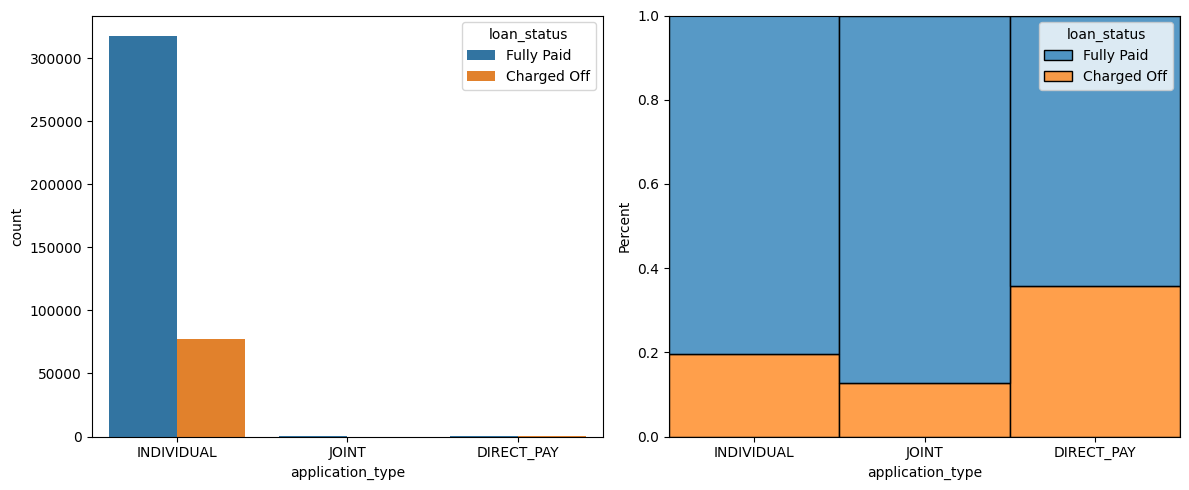

In [526]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.countplot(data=loan_data, x='application_type', hue='loan_status')
plt.subplot(1,2,2)
sns.histplot(data=loan_data, x='application_type', hue='loan_status', stat='percent', multiple='fill')
plt.tight_layout()
plt.show()

==> Majority of people are INDIVDUAL application type

- mort_acc : Number of mortgage accounts

In [527]:
loan_data['mort_acc'].value_counts().head(10)

0.0    139777
1.0     60416
2.0     49948
3.0     38049
4.0     27887
5.0     18194
6.0     11069
7.0      6052
8.0      3121
9.0      1656
Name: mort_acc, dtype: int64

In [528]:
loan_data.groupby(by='loan_status')['mort_acc'].describe().round(1)

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,72123.0,1.5,2.0,0.0,0.0,1.0,2.0,23.0
Fully Paid,286112.0,1.9,2.2,0.0,0.0,1.0,3.0,34.0


- pub_rec_bankruptcies : Number of public record bankruptcies

In [529]:
loan_data['pub_rec_bankruptcies'].value_counts()

0.0    350380
1.0     42790
2.0      1847
3.0       351
4.0        82
5.0        32
6.0         7
7.0         4
8.0         2
Name: pub_rec_bankruptcies, dtype: int64

In [530]:
loan_data.groupby(by='loan_status')['pub_rec_bankruptcies'].describe().round(1)

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,77586.0,0.1,0.4,0.0,0.0,0.0,0.0,8.0
Fully Paid,317909.0,0.1,0.4,0.0,0.0,0.0,0.0,8.0


In [531]:
(pd.crosstab(index=loan_data['loan_status'], columns=loan_data['pub_rec_bankruptcies'], normalize='columns', margins=True)*100).round(1)

pub_rec_bankruptcies,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,All
loan_status,,,,,,,,,,
Charged Off,19.5,20.4,23.2,21.1,31.7,15.6,28.6,25.0,50.0,19.6
Fully Paid,80.5,79.6,76.8,78.9,68.3,84.4,71.4,75.0,50.0,80.4


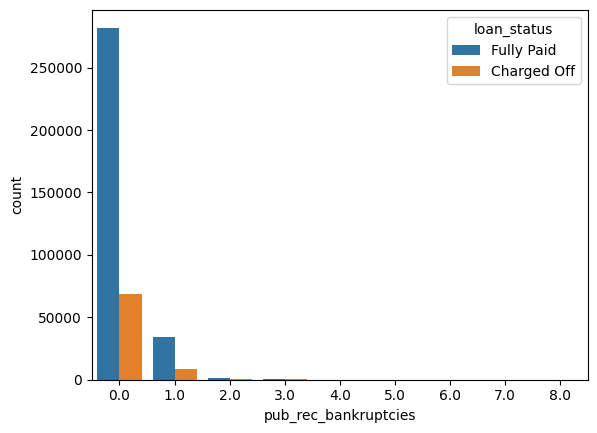

In [532]:
sns.countplot(data=loan_data, x='pub_rec_bankruptcies', hue='loan_status')
plt.show()

==> Majority of people are with no public record bankruptcies

- address: Address of the individual

In [533]:
loan_data.groupby(by='loan_status')['address'].describe().round(1)

,count,unique,top,freq
loan_status,,,,
Charged Off,77673,77520,USCGC Smith\r\nFPO AE 30723,3
Fully Paid,318357,316587,USCGC Smith\r\nFPO AE 70466,8


In [534]:
loan_data['address'].value_counts().reset_index().rename(columns={"index": "address", "address": "count"}).head(10)

,address,count
0,USCGC Smith\r\nFPO AE 70466,8
1,USS Johnson\r\nFPO AE 48052,8
2,USNS Johnson\r\nFPO AE 05113,8
3,USS Smith\r\nFPO AP 70466,8
4,USNS Johnson\r\nFPO AP 48052,7
5,USNV Smith\r\nFPO AA 00813,6
6,USCGC Smith\r\nFPO AA 70466,6
7,USCGC Jones\r\nFPO AE 22690,6
8,USNS Johnson\r\nFPO AA 70466,6
9,USNV Smith\r\nFPO AE 30723,6


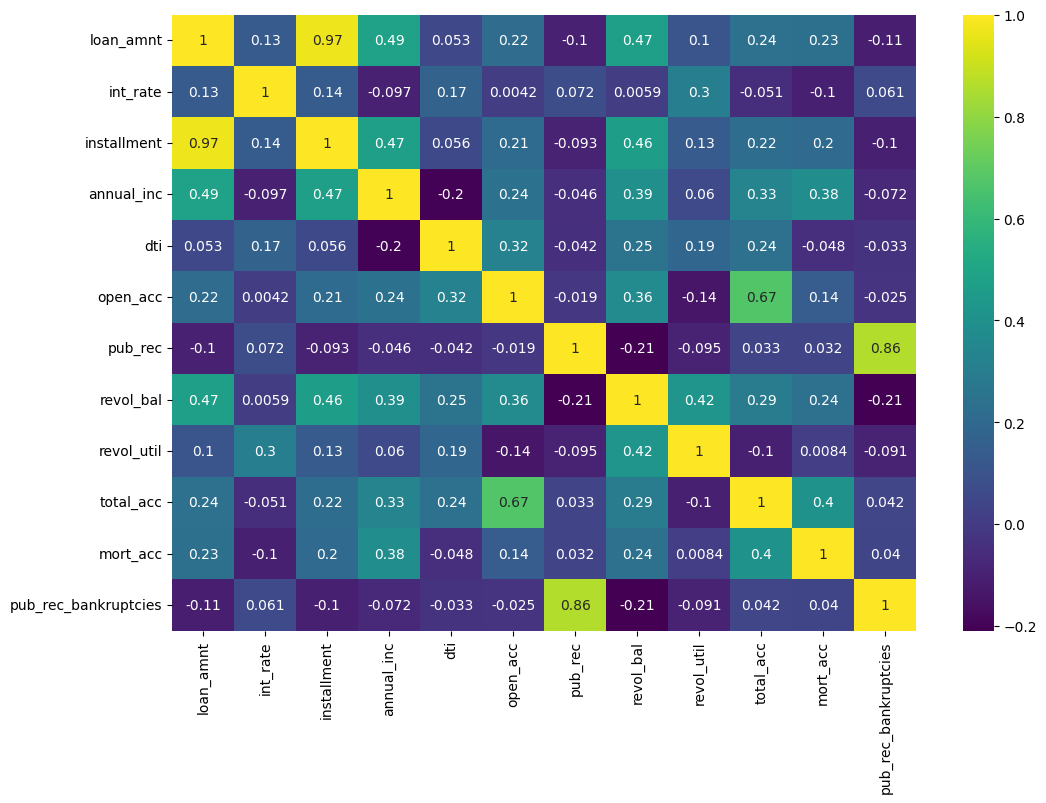

In [535]:
plt.figure(figsize=(12, 8))
sns.heatmap(loan_data.corr(method='spearman'), annot=True, cmap='viridis')
plt.show()

In [536]:
#Strong correlation between "loan_amnt" the "installment" feature, we can drop either one of those columns

loan_data.drop(columns=['installment'], axis=1, inplace=True)

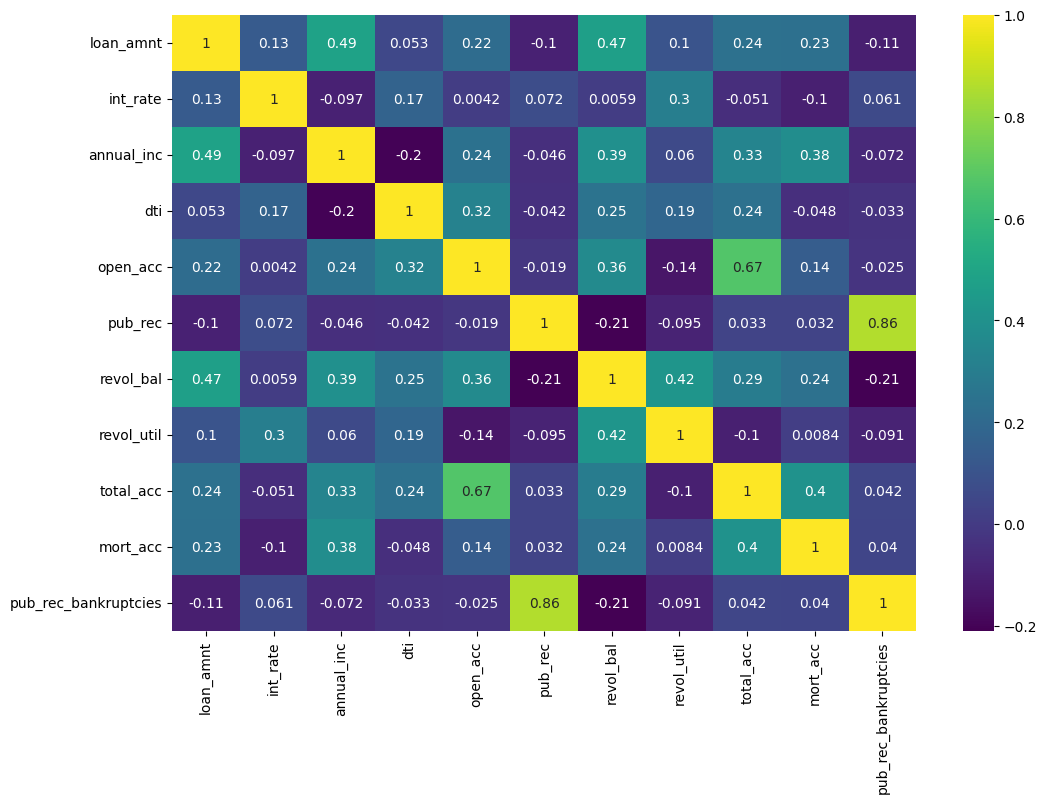

In [537]:
plt.figure(figsize=(12, 8))
sns.heatmap(loan_data.corr(method='spearman'), annot=True, cmap='viridis')
plt.show()

## Feature Engineering

In [538]:
def binary_mapper(number):
    if number == 0.0:
        return 0
    elif number >= 1.0:
        return 1
    else:
        return number

In [539]:
# Creation of Flags- If value greater than 1.0 then 1 elseif 0 then 0 else number

In [540]:
loan_data['pub_rec'] = loan_data['pub_rec'].apply(binary_mapper)
loan_data['mort_acc'] = loan_data['mort_acc'].apply(binary_mapper)
loan_data['pub_rec_bankruptcies'] = loan_data['pub_rec_bankruptcies'].apply(binary_mapper)

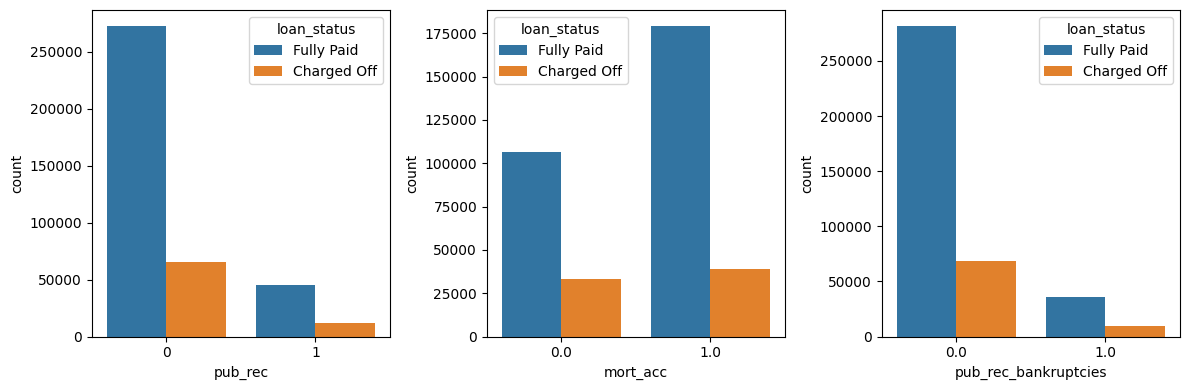

In [541]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
sns.countplot(data=loan_data, x='pub_rec', hue='loan_status')
plt.subplot(1,3,2)
sns.countplot(data=loan_data, x='mort_acc', hue='loan_status')
plt.subplot(1,3,3)
sns.countplot(data=loan_data, x='pub_rec_bankruptcies', hue='loan_status')
plt.tight_layout()
plt.show()

In [542]:
# Mapping of target variable -
loan_data['loan_status'] = loan_data['loan_status'].map({'Fully Paid':0, 'Charged Off':1})

## Missing values Treatment

__Let's check if there are any missing values in given dataset__

In [543]:
missval_list = round(loan_data.isna().sum()/loan_data.shape[0] * 100, 2)

In [544]:
for i, (col, dtype) in enumerate(zip(loan_data.columns.tolist(),loan_data.dtypes.tolist())):
    if missval_list[i] != 0.0:
        print(col, ':', missval_list[i], '%', '\tdata type:', dtype)

emp_title : 5.79 % 	data type: object
emp_length : 4.62 % 	data type: object
title : 0.44 % 	data type: object
revol_util : 0.07 % 	data type: float64
mort_acc : 9.54 % 	data type: float64
pub_rec_bankruptcies : 0.14 % 	data type: float64


so, there are 6 features with missing values in given dataset

In [545]:
loan_data['mort_acc'].unique()

array([ 0.,  1., nan])

In [546]:
# Mean Target Imputation
loan_data.groupby(by='total_acc').mean()

,loan_amnt,int_rate,annual_inc,loan_status,dti,open_acc,pub_rec,revol_bal,revol_util,mort_acc,pub_rec_bankruptcies
total_acc,,,,,,,,,,,
2,6672.222222,15.801111,64277.777778,0.222222,2.279444,1.611111,0.000000,2860.166667,53.527778,0.000000,0.000000
3,6042.966361,15.615566,41270.753884,0.220183,6.502813,2.611621,0.033639,3382.807339,49.991022,0.046243,0.015480
4,7587.399031,15.069491,42426.565969,0.214055,8.411963,3.324717,0.033118,4874.231826,58.477400,0.062140,0.019672
5,7845.734714,14.917564,44394.098003,0.203156,10.118328,3.921598,0.055720,5475.253452,56.890311,0.090789,0.039187
6,8529.019843,14.651752,48470.001156,0.215874,11.222542,4.511119,0.076634,6546.374957,57.812483,0.121983,0.050947
...,...,...,...,...,...,...,...,...,...,...,...
124,23200.000000,17.860000,66000.000000,1.000000,14.040000,43.000000,0.000000,25497.000000,75.400000,1.000000,0.000000
129,25000.000000,7.890000,200000.000000,0.000000,8.900000,48.000000,0.000000,27659.000000,8.300000,1.000000,0.000000
135,24000.000000,15.410000,82000.000000,0.000000,33.850000,57.000000,0.000000,35715.000000,50.800000,1.000000,0.000000


In [547]:
ref_val_df = loan_data.groupby(by='total_acc').mean()['mort_acc']
ref_val_df

total_acc
2      0.000000
3      0.046243
4      0.062140
5      0.090789
6      0.121983
         ...   
124    1.000000
129    1.000000
135    1.000000
150    1.000000
151    0.000000
Name: mort_acc, Length: 118, dtype: float64

In [548]:
def mean_val_imputer(reference_col, impute_col):
    if np.isnan(impute_col):
        return ref_val_df[reference_col].round()
    else:
        return impute_col

In [549]:
loan_data['mort_acc'] = loan_data.apply(lambda x: mean_val_imputer(x['total_acc'], x['mort_acc']), axis=1)

In [550]:
loan_data.loc[loan_data['emp_length'].isna(), 'emp_length'] = '10+ years'

In [551]:
loan_data['emp_length'].unique()

array(['10+ years', '4 years', '< 1 year', '6 years', '9 years',
       '2 years', '3 years', '8 years', '7 years', '5 years', '1 year'],
      dtype=object)

In [552]:
dict_map = {'10+ years':10, '4 years':4, '< 1 year':0, '6 years':6, '9 years':9,\
            '2 years':2, '3 years':3, '8 years':8, '7 years':7, '5 years':5, '1 year':1}

In [553]:
def dict_map_replace(col):
    if col in dict_map:
        return dict_map[col]
    else:
        return col

In [554]:
loan_data['emp_length'] = loan_data['emp_length'].apply(dict_map_replace)

In [555]:
missval_list = round(loan_data.isna().sum()/loan_data.shape[0] * 100, 2)
for i, (col, dtype) in enumerate(zip(loan_data.columns.tolist(),loan_data.dtypes.tolist())):
    if missval_list[i] != 0.0:
        print(col, ':', missval_list[i], '%', '\tdata type:', dtype)

emp_title : 5.79 % 	data type: object
title : 0.44 % 	data type: object
revol_util : 0.07 % 	data type: float64
pub_rec_bankruptcies : 0.14 % 	data type: float64


In [556]:
# Current no. of rows -
loan_data.shape

(396030, 26)

In [557]:
# Dropping rows with null values -
loan_data.dropna(inplace=True)

In [558]:
# Remaining no. of rows -
loan_data.shape

(370797, 26)

## Outlier Detection and Treatment

In [559]:
numerical_data = loan_data.select_dtypes(include='number')
num_cols = numerical_data.columns
len(num_cols)

13

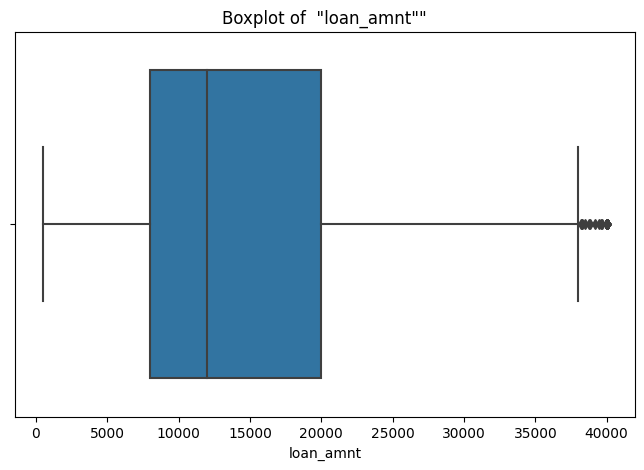

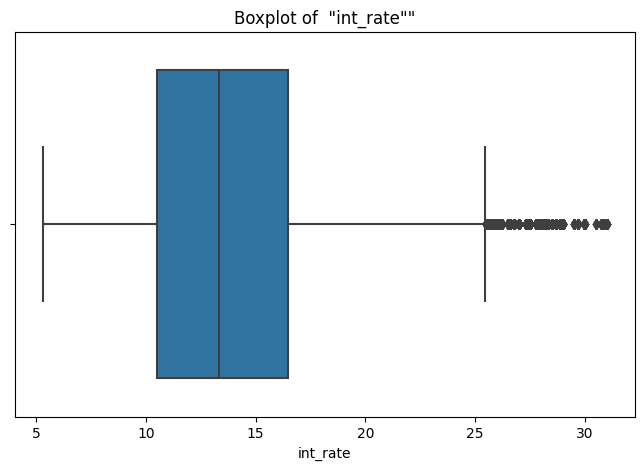

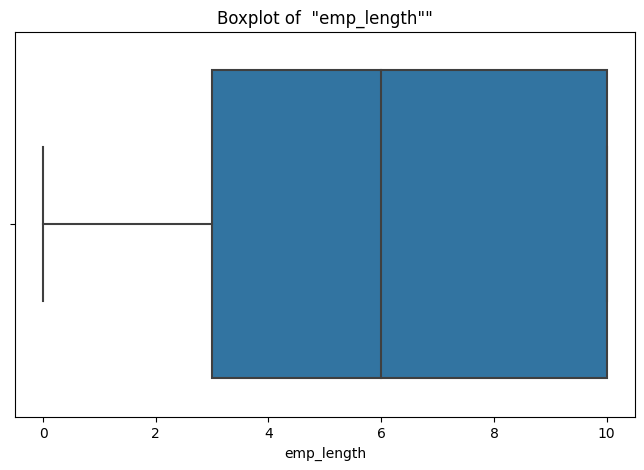

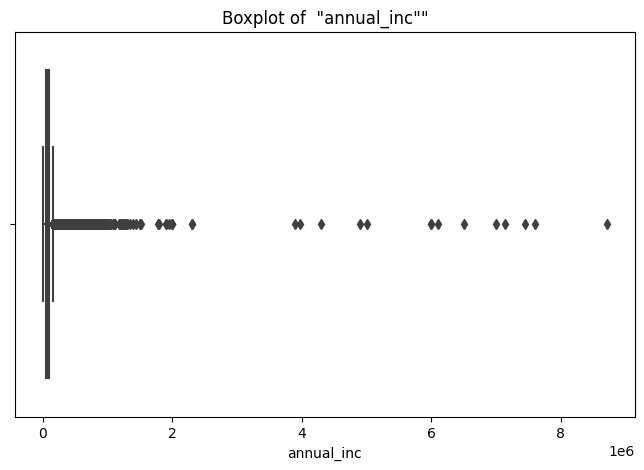

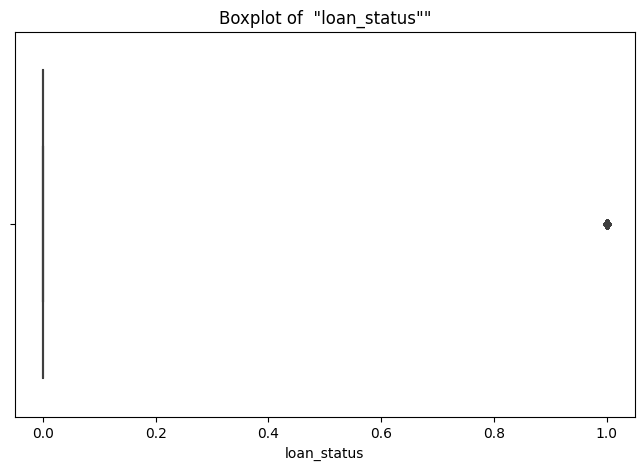

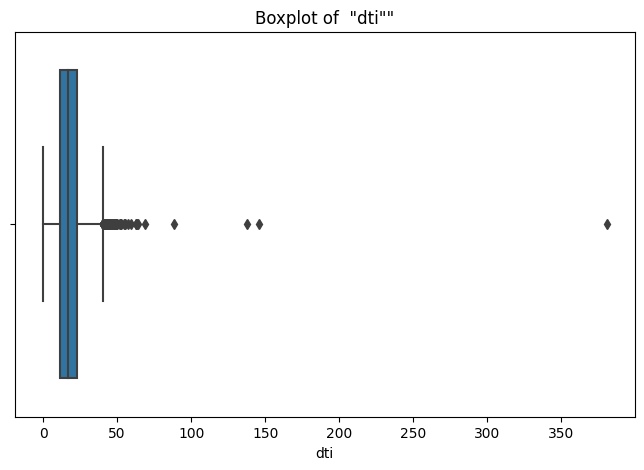

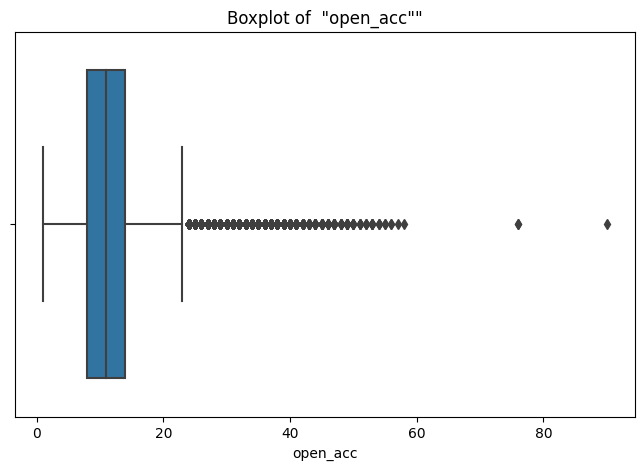

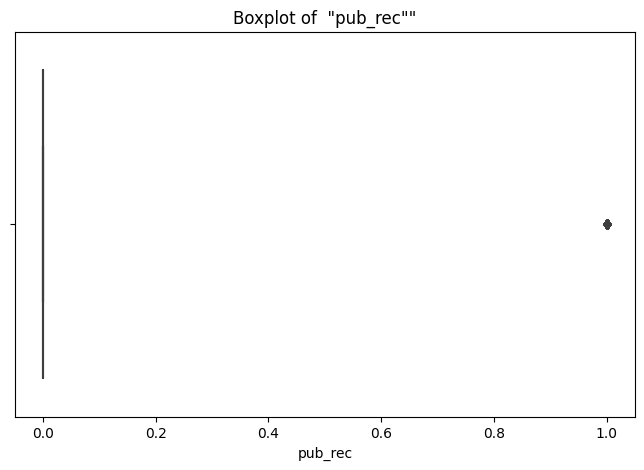

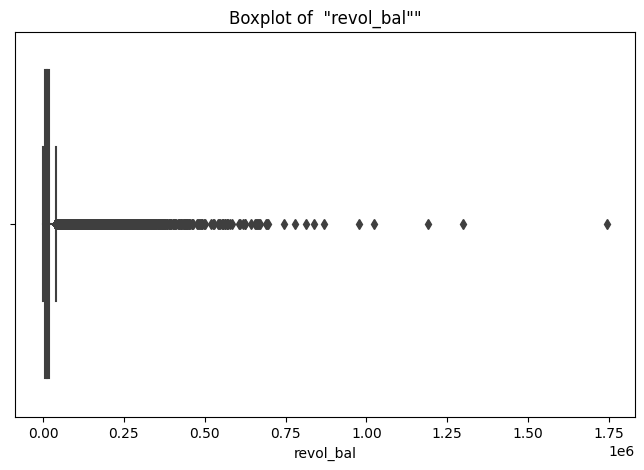

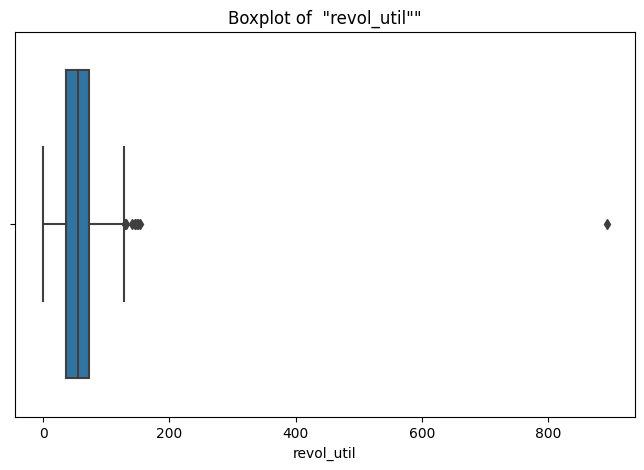

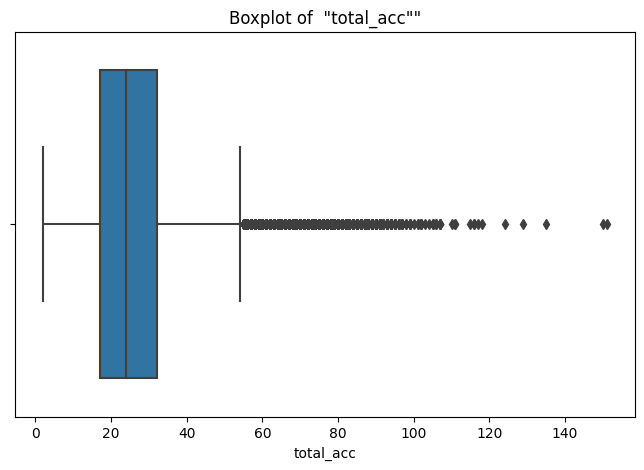

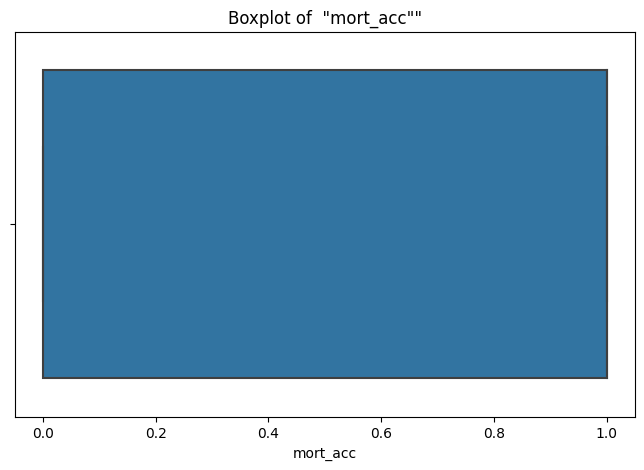

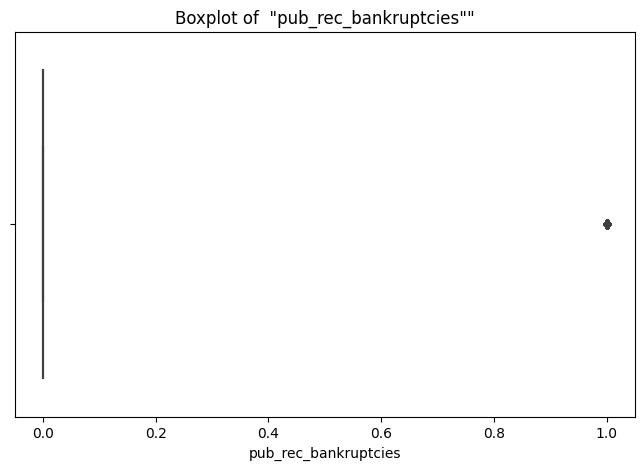

In [560]:
def box_plot(col):
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=loan_data, x=col)
    plt.title(f'Boxplot of  "{col}""')
    plt.show()
    
for col in num_cols:
    box_plot(col)

In [561]:
num_cols

Index(['loan_amnt', 'int_rate', 'emp_length', 'annual_inc', 'loan_status',
       'dti', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'mort_acc', 'pub_rec_bankruptcies'],
      dtype='object')

In [562]:
out_num_cols = ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'open_acc', 'revol_bal', 'revol_util', 'total_acc']

In [563]:
for col in out_num_cols:
    mean = loan_data[col].mean()
    std = loan_data[col].std()

    upper_limit = mean+3*std
    lower_limit = mean-3*std

    loan_data = loan_data[(loan_data[col]<upper_limit) & (loan_data[col]>lower_limit)]

In [564]:
loan_data.shape

(354688, 26)

## Data Preprocessing

In [565]:
# Term -
loan_data['term'].unique()

array([' 36 months', ' 60 months'], dtype=object)

In [566]:
term_values = {' 36 months': 36, ' 60 months': 60}
loan_data['term'] = loan_data['term'].map(term_values)

In [567]:
# Initial List Status -
loan_data['initial_list_status'].unique()

array(['w', 'f'], dtype=object)

In [568]:
list_status = {'w': 0, 'f': 1}
loan_data['initial_list_status'] = loan_data['initial_list_status'].map(list_status)

In [569]:
# Let's fetch ZIP from address and then drop the remaining details -
loan_data['zip_code'] = loan_data['address'].apply(lambda x: x[-5:])

In [570]:
# Dropping some variables which we can let go for now -
loan_data.drop(columns=['issue_d', 'emp_title', 'title', 'sub_grade', 'address', 'earliest_cr_line'], axis=1, inplace=True)

In [571]:
obj_cols = loan_data.select_dtypes(include='object').columns.tolist()
obj_cols

['grade',
 'home_ownership',
 'verification_status',
 'purpose',
 'application_type',
 'zip_code']

__One-hot Encoding__

In [572]:
dummies = obj_cols
loan_data = pd.get_dummies(loan_data, columns=dummies, drop_first=True)

In [573]:
loan_data.shape

(354688, 50)

In [574]:
num_cols = loan_data.select_dtypes(include='number').columns.tolist()
print('number of columns in data: ', loan_data.shape[1], '\ncolumns with number: ', len(num_cols)) 

number of columns in data:  50 
columns with number:  50


## Data Preparation for Modeling

In [575]:
X = loan_data.drop('loan_status', axis=1)
y = loan_data['loan_status']

In [576]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y, random_state=42)

In [577]:
print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of X_test: {X_test.shape}')

Shape of X_train: (248281, 49)
Shape of X_test: (106407, 49)


__Scaling - Using MinMaxScaler or StandardScaler__

In [578]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Logistic Regression

In [580]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [586]:
y_pred = logreg.predict(X_test)
print('Accuracy of Logistic Regression Classifier on test set: {:.3f}'.format(logreg.score(X_test, y_test)))

Accuracy of Logistic Regression Classifier on test set: 0.892


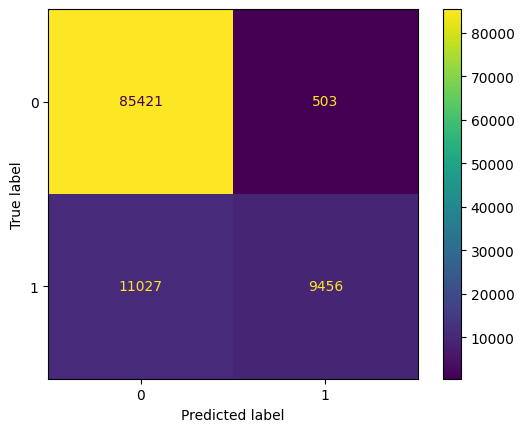

In [606]:
cm = confusion_matrix(y_test, y_pred)
dispCM = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg.classes_)
dispCM.plot(cmap='viridis')
plt.show()

__Classification Report__

In [607]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.99      0.94     85924
           1       0.95      0.46      0.62     20483

    accuracy                           0.89    106407
   macro avg       0.92      0.73      0.78    106407
weighted avg       0.90      0.89      0.88    106407



__ROC AUC curve__

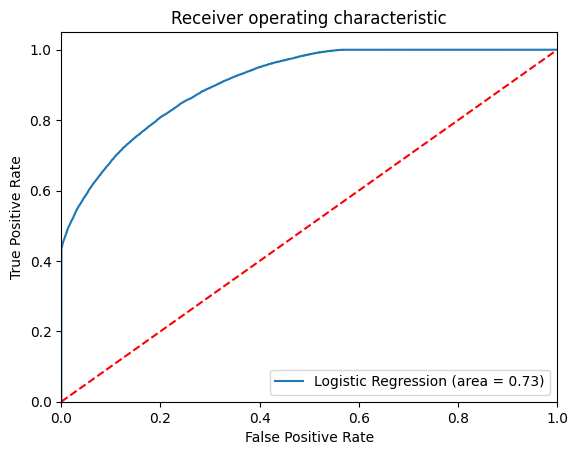

In [608]:
logit_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
plt.show()

__Precision recall curve__

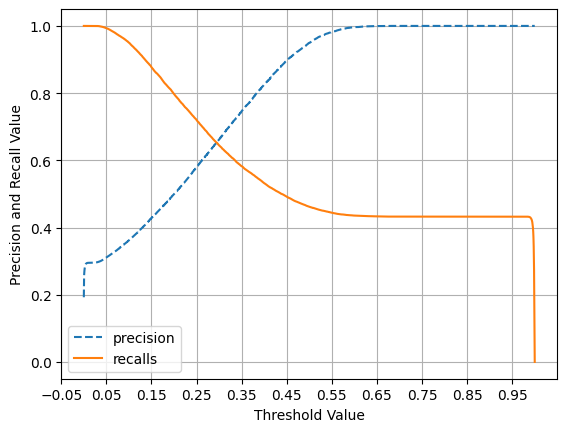

In [609]:
def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    threshold_boundary = thresholds.shape[0]
    # plot precision
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    # plot recall
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recalls')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    plt.xlabel('Threshold Value') 
    plt.ylabel('Precision and Recall Value')
    plt.legend()
    plt.grid()
    plt.show()
    
precision_recall_curve_plot(y_test, logreg.predict_proba(X_test)[:,1])

In [638]:
logreg.coef_.round(1)

array([[ 0.6,  0.4,  0.2, -0.1, -1.2,  1.1,  0.7,  0.2, -0.5,  0.4, -0.6,
        -0. , -0.1, -0.2,  0.6,  1. ,  1.3,  1.5,  1.6,  1.6,  0.3,  0.1,
         0.2,  0.2,  0.1,  0.1,  0.2,  0.6,  0.3,  0.2,  0.2,  0.4,  0.3,
         0.2,  0.4,  0.7,  0.2, -0.2,  0.4, -0.7, -2.9, 12.7,  4.9, -2.9,
         4.9,  4.9,  4.9, 12.6, 12.7]])

In [639]:
logreg.intercept_

array([-8.71843748])

In [637]:
pd.DataFrame(zip(loan_data.drop('loan_status', axis=1).columns, np.transpose(logreg.coef_.round(2))), columns=['features', 'coef'])

,features,coef
0,loan_amnt,[0.6]
1,term,[0.44]
2,int_rate,[0.17]
3,emp_length,[-0.05]
4,annual_inc,[-1.2]
5,dti,[1.05]
6,open_acc,[0.66]
7,pub_rec,[0.21]
8,revol_bal,[-0.48]
9,revol_util,[0.44]


__Multicollinearity check using Variance Inflation Factor (VIF)__

In [610]:
def calc_vif(X):
    # Calculating the VIF
    vif = pd.DataFrame()
    vif['Feature'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by='VIF', ascending = False)
    return vif

calc_vif(X)[:5]

,Feature,VIF
38,application_type_INDIVIDUAL,158.16
2,int_rate,122.90
26,purpose_debt_consolidation,50.98
1,term,27.30
25,purpose_credit_card,18.47


In [611]:
X.drop(columns=['application_type_INDIVIDUAL'], axis=1, inplace=True)
calc_vif(X)[:5]

,Feature,VIF
2,int_rate,103.86
26,purpose_debt_consolidation,27.79
1,term,24.36
6,open_acc,13.78
10,total_acc,12.73


In [612]:
X.drop(columns=['int_rate'], axis=1, inplace=True)
calc_vif(X)[:5]

,Feature,VIF
1,term,23.43
25,purpose_debt_consolidation,22.84
5,open_acc,13.66
9,total_acc,12.73
8,revol_util,9.06


In [613]:
X.drop(columns=['term'], axis=1, inplace=True)
calc_vif(X)[:5]

,Feature,VIF
24,purpose_debt_consolidation,19.03
4,open_acc,13.66
8,total_acc,12.70
7,revol_util,9.05
2,annual_inc,8.04


In [614]:
X.drop(columns=['purpose_debt_consolidation'], axis=1, inplace=True)
calc_vif(X)[:5]

,Feature,VIF
4,open_acc,13.09
8,total_acc,12.69
7,revol_util,8.35
2,annual_inc,7.74
3,dti,7.63


In [615]:
X.drop(columns=['open_acc'], axis=1, inplace=True)
calc_vif(X)[:5]

,Feature,VIF
7,total_acc,8.29
6,revol_util,8.05
2,annual_inc,7.64
3,dti,7.07
0,loan_amnt,6.73


In [617]:
X = scaler.fit_transform(X)

kfold = KFold(n_splits=5)
accuracy = np.mean(cross_val_score(logreg, X, y, cv=kfold, scoring='accuracy', n_jobs=-1)) 
print("Cross Validation accuracy: {:.3f}".format(accuracy))

Cross Validation accuracy: 0.891


## Precision Vs Recall Tradeoff

In [643]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.30, stratify=y, random_state=42)

In [644]:
print(f'Shape of X_train1: {X_train1.shape}')
print(f'Shape of X_test1: {X_test1.shape}')

Shape of X_train1: (248281, 44)
Shape of X_test1: (106407, 44)


### Oversampling using SMOTE

In [645]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train1, y_train1.ravel())

In [646]:
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

After OverSampling, the shape of train_X: (400978, 44)
After OverSampling, the shape of train_y: (400978,) 

After OverSampling, counts of label '1': 200489
After OverSampling, counts of label '0': 200489


__Logistic Regression__

In [647]:
lr1 = LogisticRegression(max_iter=1000)
lr1.fit(X_train_res, y_train_res)

LogisticRegression(max_iter=1000)

In [650]:
y_pred1 = lr1.predict(X_test1)
print('Accuracy of Logistic Regression Classifier on test set: {:.3f}'.format(lr1.score(X_test1, y_test1)))

Accuracy of Logistic Regression Classifier on test set: 0.796


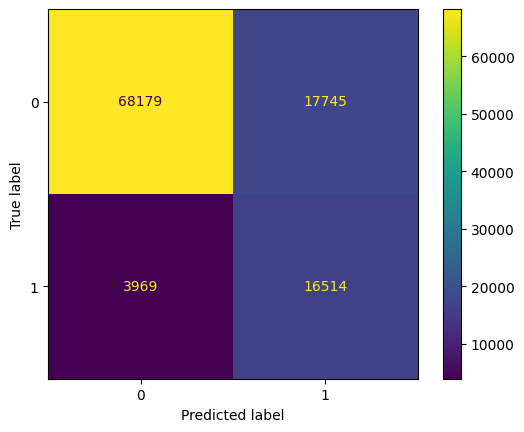

In [651]:
cm = confusion_matrix(y_test1, y_pred1)
dispCM = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg.classes_)
dispCM.plot(cmap='viridis')
plt.show()

__Classification Report__

In [652]:
print(classification_report(y_test1, y_pred1))

              precision    recall  f1-score   support

           0       0.94      0.79      0.86     85924
           1       0.48      0.81      0.60     20483

    accuracy                           0.80    106407
   macro avg       0.71      0.80      0.73    106407
weighted avg       0.86      0.80      0.81    106407



__ROC AUC curve__

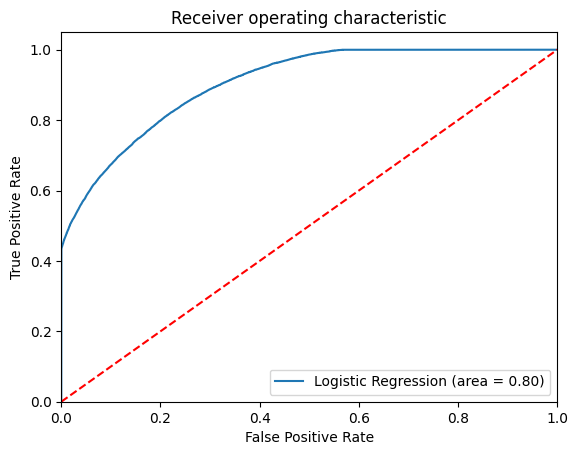

In [653]:
logit_roc_auc1 = roc_auc_score(y_test1, y_pred1)
fpr1, tpr1, thresholds1 = roc_curve(y_test1, lr1.predict_proba(X_test1)[:,1])
plt.figure()
plt.plot(fpr1, tpr1, label='Logistic Regression (area = %0.2f)' % logit_roc_auc1)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
plt.show()

__Precision recall curve__

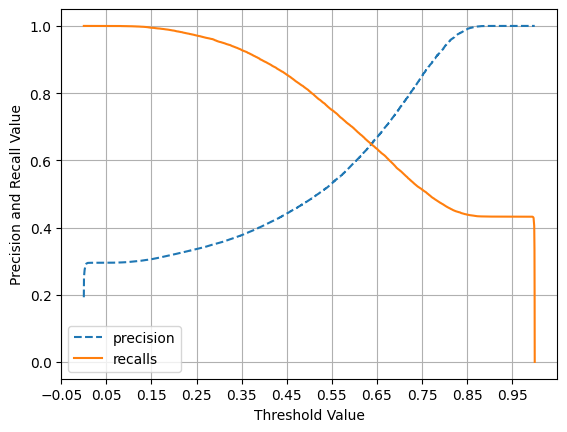

In [654]:
def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    threshold_boundary = thresholds.shape[0]
    # plot precision
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    # plot recall
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recalls')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    plt.xlabel('Threshold Value'); plt.ylabel('Precision and Recall Value')
    plt.legend(); plt.grid()
    plt.show()
    
precision_recall_curve_plot(y_test1, lr1.predict_proba(X_test1)[:,1])

In [655]:
lr1.coef_.round(1)

array([[ 1.1, -0. , -1.8,  1.2, -0. , -0.4,  0.3, -0.3, -0. , -0. , -0. ,
         0.7,  1.2,  1.6,  1.9,  2.1,  2.1, -0.1, -0. ,  0.2,  0.2,  0.1,
        -0.1, -0.1, -0. , -0.6, -0.3, -0.3, -0.4, -0.2, -0.4,  0.2, -0.5,
        -0.9, -1.7, -3. , 13.8,  6.2, -3. ,  6.2,  6.2,  6.2, 13.8, 13.8]])

In [656]:
lr1.intercept_

array([-7.77558491])

In [657]:
pd.DataFrame(zip(loan_data.drop(['loan_status','application_type_INDIVIDUAL','int_rate','term', \
                                 'purpose_debt_consolidation','open_acc'], axis=1).columns, \
                                 np.transpose(lr1.coef_.round(2))), columns=['features', 'coef'])

,features,coef
0,loan_amnt,[1.05]
1,emp_length,[-0.03]
2,annual_inc,[-1.82]
3,dti,[1.2]
4,pub_rec,[-0.01]
5,revol_bal,[-0.45]
6,revol_util,[0.33]
7,total_acc,[-0.26]
8,initial_list_status,[-0.03]
9,mort_acc,[-0.04]
